# Projet Recherche Opérationnelle

Antoine GICQUEL \
Victor BERTRET \
4ème année Génie Mathématique \
Année universitaire 2020 - 2021

*Importation des packages nécessaires:*

In [45]:
from pulp import* #Package pulp : resolution de modeles PLNE
import numpy as np #Traitement de listes
import random as random #Aleatoire
import time #Temps
import matplotlib.pyplot as plt #Graphiques
from matplotlib import style #Graphiques
from operator import itemgetter, attrgetter #tuples
from heapq import * #Tas binaires
import networkx as nx #Affichage graphes
style.use('ggplot')

## Introduction

Ce projet a été réalisé dans le cadre du module de Recherche Opérationnelle de notre formation d'ingénieur au département Génie Mathématique de l'INSA de Rennes. L'objectif de ce projet était d'étudier le fonctionnement de l'algorithme de Branch-and-Bound appliqué au problème d'ordonnancement qui est le suivant. On considère un atelier de production devant usiner un ensemble $J = \{1,...,n\}$ de pièces. On suppose que l'atelier ne dispose que d'une machine (le problème peut tout à fait être étendu au cas où l'atelier dispose de plusieurs machines). Chaque pièce $j\in J$ nécessite $p_j$ unités de temps pour être usinée. De plus, à la date $t=0$, chaque pièce $j\in J$ doit être usinée avant la date $d_j$. Si ce n'est pas le cas et que la pièce $j$ est prête après la date $d_j$ alors il faudra payer une pénalité de $\omega_j$ par unité de temps de retard. On cherche à trouver l'ordre d'usinage des pièces minimisant la somme totale des pénalités de retard. \
Notons dès maintenant que ce problème peut être modélisé sous la forme d'un programme linéaire en nombres entiers que nous avons explicité ci-dessous :


**Variables:**

 * $\forall j \in J, r_j \ge 0$ est une variable réelle positive représentant le retard en unités de temps de la pièce $j$
 
 * $\forall j \in J, f_j \ge 0$ est une variable réelle positive représentant la date de fin d'usinage de la pièce $j$
 
 * $\forall (i,j)\in J^2$, $x_{i,j} \in \{0,1\}$ est une variable binaire prenant la valeur $1$ si la pièce $i$ passe avant la pièce $j$ et $0$ sinon

**Objectif:**

* On cherche à minimiser les pénalités de retard :

$$ \min{\sum_{j\in J}{\omega_j r_j}}$$

**Contraintes:**

* On impose la contrainte suivante pour calculer le retard de chaque pièce :
$$ r_j \ge f_j - d_j,\quad \forall j \in J$$

* On impose la contrainte suivatne pour calculer la date de fin d'usinage de chaque pièce :
$$ f_j = T_j + \sum_{i \in J \\ i\neq j}{T_i x_{ij}} \quad \forall j \in J$$

* On impose enfin une relation d'ordre totale sur le passage des pièces :
$$ x_{ij} + x_{ji} = 1 \quad \forall (i,j) \in J^2, \: i < j$$
$$ x_{ik} \ge x_{ij} + x_{jk}-1\quad \forall (i,j,k) \in J^3, \: i<j, \: i<k, j\neq k$$

\
Nos implémentations ont été réalisées sous Python et nous avons fait appel (lorsque c'était nécessaire) au package PuLP pour résoudres des PLNE.

Nous avons dans un premier temps créé une structure de données permettant de représenter une instance du problème d'ordonnacement présenté ci-dessus. Nous avons ensuite créé une structure de données générique pour l'arbre d'énumération qui sera utilisée dans l'algorithme de Branch-and-Bound. Avec celle-ci, nous avons par la suite, implémenté l'algorithme de Branch-and-bound de manière générique, en fragmentant ses différentes spécificités dans des sous-fonctions. Ceci nous a notament permis de tester plusieurs méthodes et ainsi de comparer leurs performances sur des instances du problème d'ordonnancement. Les résultats et analyses de nos tests sont détaillés dans ce notebook. Enfin nous avons programmé des fonctions permettant de visualiser le parcours de l'arbre de branchement de l'algorithme de Branch-And-Bound selon les méthodes utilisées. Nous présenterons également une résolution de l'extension du problème d'ordonnancement dans laquelle nous ajoutons des contraintes de précédence entre certaines paires de pièces à usiner.

## I - Structure de données générique pour le problème d'ordonnancement

Afin de représenter les caractéristique du problème d'ordonnancement (celui présenté en introduction), nous avons choisi de définir une classe *Ordonnancement* en Python. Nous devrons donc créer un objet issu de la classe Ordonnancement à chaque fois que l'on souhaitera traiter une instance du problème d'ordonnancement.\
Le code de la classe est donné ci-dessous. Chaque problème d'ordonnancement contiendra les attributs suivants:
* **nb_piece** : le nombre de pièces contenues dans le problème (qui seront indexés de 0 à *nb_piece*-1)
* **unite_temps** : une liste contenant les unités de temps $T_j$ nécessaires pour l'usinage de chaque pièce $j$ (ces valeurs sont rangées dans l'ordre croissant des indices des pièces) 
* **deadlines** : une liste contenant les dates limites (deadlines) d'usinage $d_j$ de chaque pièce $j$ (ces valeurs sont rangées dans l'ordre croissant des indices des pièces)
* **penalites** : une liste contenant les valeurs des pénalités de retard $\omega_j$ par unité de temps de chaque pièce $j$ (ces valeurs sont rangées dans l'ordre croissant des indices des pièces)
* **contraintesPrecedence** : un tableau associatif qui gardera en mémoire les contraintes de précédences imposées sur les pièces en indiquant pour chaque pièce présente en entrée, les autres pièces qui doivent être usinées avant celle-ci (Nous traiterons les contraintes de précédences sur les pièces dans un second temps).

De même, la classe *Ordonnancement* contient les fonctions suivantes:

* **ajoutePieces(...)** : fonction permettant d'ajouter un ensemble de pièces au problème. Elle prend en paramètre une liste contenant les unités de temps des pièces à ajouter, une liste contenant les deadlines des pièces à ajouter et une liste contenant les pénalités par unité de temps des pièces à ajouter (notons que les 3 listes passées en paramètre doivent avoir la même longueur).
* **ajouterContraintePrecedence(...)** : fonction permettant d'ajouter des contraintes de précédence sur l'ordre de passage des pièces. Elle prend en paramètre la pièce à ajouter et une liste contenant les pièces devant passer avant cette dernière
* **afficherProbleme()** : fonction permettant d'afficher les données du problème (valeurs de $T_j$, $\omega_j$ et $d_j$ $\forall j \in J$ ainsi que les éventuelles contraintes de précédence).
* **problemeAleatoire(...)** : fonction permettant de créer une instance aléatoire contienant $n$ objets(donné en paramètre et fixé par défaut à 10). Notons que cette fonction créé une nouvelle instance en écrasant la précédente contenue dans l'objet.
* **resolutionPLNE(...)** : fonction permettant de modéliser le problème courant sous la forme du PLNE présenté en introduction et qui le résout en affichant son résultat (et en indiquant éventuellement si l'instance proposée est non-réalisabe). Elle prend en paramètre un booléen permettant d'afficher ou non la valeur des variables après la résolution.

In [46]:
class Ordonnancement:
    
    def __init__(self):
        self.nb_piece=0 #Nombre de pieces
        self.unite_temps=[] #Unites de temps necessaires pour les pieces
        self.deadlines=[] #Deadlines pour chaque piece
        self.penalites=[] #Pénalites pour les retards de chaque piece
        self.contraintesPrecedence = {} #Contraintes de precedence entre les pieces
        
    def ajouterPieces(self,liste_ut,liste_d,liste_p):
        #On verifie qu'il ne manque pas d'informations
        if(len(liste_ut) == len(liste_d) == len(liste_p)):
            self.nb_piece += len(liste_ut) #Augmentation du nombre de pieces
            self.unite_temps += liste_ut #Ajout des unites de temps des nouvelles pieces
            self.deadlines += liste_d #Ajout des deadlines des nouvelles pieces
            self.penalites += liste_p #Ajout des penalites des nouvelles pieces
        else:
            print("Attention les listes doivent être de même longueur")
    
    #Fonction permettant d'imposer que les pieces de la liste 'pieces_precedentes' passent avant 'piece'
    def ajouterContraintePrecedence(self,piece,pieces_precedentes):
        if(piece >= self.nb_piece):
            #La piece doit être dans la liste pour lui imposer des contraintes de precedence
            print("Attention ! La pièce",piece,"n'a pas encore été ajoutée")
        else:
            #On ajoute les contraintes de precedence
            if piece not in self.contraintesPrecedence:
                self.contraintesPrecedence[piece] = pieces_precedentes
            else:
                for p in pieces_precedentes:
                    self.contraintesPrecedence[piece].append(p)
    
    #Fonction permettant d'afficher les donnees du problemes cree
    def afficherProbleme(self):
        print("\nAFFICHAGE DU PROBLEME:\n")
        print("############### PIECES ##############")
        for i in range(self.nb_piece):
            print("Piece n°",i,": [Unités de temps nécessaires: ",self.unite_temps[i],", Deadline: ",self.deadlines[i],", Pénalité par unité de temps de retard: ",self.penalites[i],"]")
        print("###### CONTRAINTES PRECEDENCES ######")
        if(len(self.contraintesPrecedence) ==  0):
            print("Pas de contraintes de précédence")
        else:
            for i in self.contraintesPrecedence:
                for j in self.contraintesPrecedence[i]:
                    print("La pièce",j,"doit passer avant la pièce",i)
    
    #Fonction permettant de creer une instance de n pieces aux valeurs aleatoire 
    def problemeAleatoire(self,n = 10):
        self.nb_piece = n #Nombre de pieces
        self.unite_temps = [random.randint(1,20) for i in range(n)] #Unites de temps
        self.deadlines = [random.randint(20,40) for i in range(n)] #Deadlines
        self.penalites = [random.randint(1,10) for i in range(n)] #Pénalites
        
        
    def resolutionPLNE(self,afficheTout=1):
        #Création du modele:
        modele = LpProblem("Ordonnancement",LpMinimize)
        #Ensembles des pieces
        J = list(range(self.nb_piece))
        #Variables:
        r = LpVariable.dicts("r",J,0,None,LpContinuous) #Retard de chaque piece
        f = LpVariable.dicts("f",J,0,None,LpContinuous) #Date de fin d'usinage de chaque piece
        x = LpVariable.matrix("x",(J,J),0,1,LpInteger) #Ordre de passage des pieces
        #Objectif:
        modele += pulp.lpSum([self.penalites[j]*r[j] for j in J]) #Minimisation des penalites de retard
        #Contraintes:
        
        for j in J:
            modele += r[j] >= f[j] - self.deadlines[j] #Calcul du retard
        
        for j in J:
            modele += f[j] == self.unite_temps[j] + lpSum([self.unite_temps[i]*x[i][j] for i in J if i != j]) #Calcul des dates de fin d'usinage
        
        for j in J:
            modele += x[j][j] == 0 #Une piece ne peut pas passer avant elle-meme
        
        for j in J:
            for i in range(j):
                modele += x[i][j] + x[j][i] == 1 #Impose l'ordre total sur la relation d'ordre
        
        for j in J:
            for i in J:
                for k in J:
                    if(i<j and i<k and j != k):
                        modele += x[i][k] >= x[i][j] + x[j][k]- 1 #Impose la transitivite sur la relation d'ordre
        
        for j in self.contraintesPrecedence:
            for i in self.contraintesPrecedence[j]:
                modele += x[i][j] == 1 #Impose la contrainte de precedence : i doit passer avant j
        
        if(afficheTout):
            print("\nSOLUTION OBTENUE PLNE:\n")
            #Resolution du probleme:
            print("Solve with CBC",end=", ")
            modele.solve(pulp.PULP_CBC_CMD())
            #Affichage de la solution
            print("Status:",LpStatus[modele.status])

            #Si la solution est optimale, on affiche le resultat
            if(LpStatus[modele.status] == "Optimal"):
                print("Total des pénalités:",value(modele.objective))
                #Reconstruction de l'ordre des pieces
                Ordre = []
                k = self.nb_piece - 1
                while(k >= 0):
                    for i in J:
                        if(sum([value(x[i][j]) for j in J]) == k):
                            Ordre.append(i)
                    k -= 1
                print("Ordre d'usinage des pièces:",Ordre)
            else:
                print("Erreur lors de la résolution")

Pour illustrer le fonctionnement de cette classe, nous allons considérer l'exemple suivant composé de $n=4$ pièces (on considérera tout au long du projet $J=\{0,...,n-1\}$ pour que les éléments de $J$ coïncident avec les indices des pièces dans les listes) ainsi que les valeurs correspondantes de $\omega_j$, $T_j$ et $d_j$ pour chaque pièce $j$.

![title](Exemple.PNG)

Nous commencons par construire un objet correspondant au problème d'ordonnancement associé au tableau ci-dessus:

In [47]:
Exemple = Ordonnancement()
P = [4,5,3,5] #Penalites
T = [12,8,15,9] #Unites de temps necessaires
D = [16,26,25,27] #Deadlines
Exemple.ajouterPieces(T,D,P)
Exemple.afficherProbleme()


AFFICHAGE DU PROBLEME:

############### PIECES ##############
Piece n° 0 : [Unités de temps nécessaires:  12 , Deadline:  16 , Pénalité par unité de temps de retard:  4 ]
Piece n° 1 : [Unités de temps nécessaires:  8 , Deadline:  26 , Pénalité par unité de temps de retard:  5 ]
Piece n° 2 : [Unités de temps nécessaires:  15 , Deadline:  25 , Pénalité par unité de temps de retard:  3 ]
Piece n° 3 : [Unités de temps nécessaires:  9 , Deadline:  27 , Pénalité par unité de temps de retard:  5 ]
###### CONTRAINTES PRECEDENCES ######
Pas de contraintes de précédence


Une fois ce problème créé, nous pouvons maintenant le résoudre avec le modèle PLNE associé en appelant la fonction  *resolutionPLNE(...)*.

In [48]:
Exemple.resolutionPLNE() #Resolution 


SOLUTION OBTENUE PLNE:

Solve with CBC, Status: Optimal
Total des pénalités: 67.0
Ordre d'usinage des pièces: [0, 1, 3, 2]


On obtient que la valeur optimale du problème est $z^*=67$ (valeur optimale de la fonction objectif du PLNE) et un ordre correspondant à cette solution est le suivant $x^* = (0,1,3,2)$ (Il peut y en avoir d'autres).\
Nous pourrons ainsi vérifier plus loin si notre algorithme de Branch-And-Bound nous fournit également cette valeur optimale.

## II - Structure de données générique pour l'arbre d'énumération de l'algorithme de Branch-And-Bound

Après avoir implémenté la structure de données génériques pour le problème d'ordonnancement, nous allons nous intéresser à la mise en place de l'algorithme de Branch-and-Bound. Premièrement, nous devons créer une structure de données génériques pour l'arbre d'énumération.

Pour cela, nous séparons la création de l'arbre en 2 étapes. Tout d'abord, nous créons une classe Noeud. Cette classe noeud regroupe les informations dont nous avons besoin pour chaque noeud :

* **description** : titre du noeud.


* **position** : elle permet de savoir si le noeud est à l'extrémité de l'arbre ( feuille) ou non ( branche ).


* **indice_pere** : elle nous donne la position du noeud père dans la liste des noeuds que nous allons vous présenter par la suite dans une deuxième classe. Le noeud racine prendra la valeur -1.


* **info** : cette variable permet de décrire un noeud. Dans notre cas, elle contiendra la plupart du temps, l'ordre des pièces déjà fixées.

Voici l'implémentation de la classe Noeud en python :

In [49]:
class Noeud:
    def __init__(self,description,pos,info =[],indice=-1):
        self.description=description
        self.position = pos #branche : 0 ou une feuille : 1
        self.indice_pere = indice #-1 si noeud racine
        self.info = info

Ensuite, dans un second temps, nous créons la classe ArbreEnumeration. Cette classe permet de définir l'arbre qui va être utilisé par la suite dans l'algorithme de Branch-and-Bound. Celle-ci va donc permettre de stocker tous les noeuds de l'arbre. 
Chaque instance de la classe est constituée des attributs suivants :

* **nombre_noeuds** : nombre de noeuds de l'arbre crée suite à l'algorithme B&B


* **nombre_noeuds_non_traites** : nombre de noeuds qui n'ont pas encore été traités


* **noeuds** : liste regroupant tous les noeuds


* **indice_noeuds_non_traites** : liste regroupant les indices de la liste noeud (des noeuds qui n'ont pas encore été traités)



* **primal_bound** : borne primale du problème


Voici l'implémentation de la classe ArbreEnumeration en python : 

In [50]:
class ArbreEnumeration:
    
    def __init__(self,p1):
            self.nombre_noeuds=1
            self.nombre_noeuds_non_traites = 1
            self.noeuds = [Noeud("Problème initiale",False)]
            self.indice_noeuds_non_traites= [0]
            self.primal_bound=p1

La structure de l'arbre d'énumération est maintenant implémentée. 

## III - Implémentation de l'algorithme de Branch-And-Bound dans le cadre du problème d'ordonnancement

Nous devons maintenant implémenter l'algorithme de Brand-and-Bound. Lorsque nous voulons appliquer l'algorithme B&B à un problème particulier, dans notre cas le problème d'ordonnancement, nous devons spécifier :


* **calcul de la borne duale** : Nous devons spécifier à l'algorithme comment calculer la borne duale de chaque noeud.


* **règle de branchement** : Nous devons spécifier la règle de branchement, c'est-à-dire spécifier à l'algorithme comment créer les noeuds enfants.


* **borne primale initiale** : Nous devons donner à l'algorithme une première borne primale initiale. Celle-ci n'est pas obligatoire mais elle permet d'accélérer grandement l'exécution l'algorithme. 


* **méthode d'exploration** : Nous devons spécifier à l'algorithme comment parcourir l'arbre d'énumération.

Ainsi, notre objectif ést de créer l'implémentation la plus générique possible et de créer des variantes de l'algorithme en modifiant les élements que nous venons de présenter ci-dessus. Pour cela, notre fonction B&B prend en paramètre l'instance du problème, la borne primale initiale, le calcul de la borne duale, la règle de branchement ainsi que la méthode d'exploration.

Ensuite, afin d'implémenter l'algorithme de B&B, nous suivons le pseudocode présenté ci-dessous : 

![image.png](img/pseudocode-B&B.PNG)

Pour simplifier l'algorithme, nous allons créer quelques fonctions externes. Premièrement, nous créons une fonction **recuperationNoeud**. Celle-ci a pour objectif de récupérer un noeud de la liste des noeuds non traités et de calculer sa borne duale (ligne 5 à 7). 


Pour cela, la méthode prend en paramètre les éléments suivants : **arbre**, l'arbre d'énumération associé à l'algorithme ( instance de la classe ArbreEnumeration ), **explo**, la méthode d'exploration, **k**, le nombre d'itérations, **borne_duale**,  la méthode pour calculer la borne duale et **instance**, le probleme que nous voulons résoudre.


En retour, la méthode peut ainsi renvoyer les éléments suivants :


* **Pk** : l'indice du noeud qui est en train d'être traité


* **zD** : borne duale du noeud indicé par Pk


* **isOptimal** : variable booléenne indiquant si le noeud est une feuille ( vrai ) ou bien une branche ( faux )


* **solution** : solution réalisable du noeud si le noeud est un noeud feuille

Voici son implémentation en python :

In [51]:
def recuperationNoeud(arbre,explo,k,borne_duale,instance): 
    Pk = arbre.indice_noeuds_non_traites.pop()
    
    arbre.nombre_noeuds_non_traites-=1
    
    #Calcul de la borne dual de Pk
    zD, isOptimal, solution  = borne_duale(arbre.noeuds[Pk],instance)
    #isOptimal == pos du noeud
    
    return Pk, zD, isOptimal, solution

Deuxièmement, nous créons une deuxième fonction externe : **exploration** (ligne 13). Pour l'instant, cette fonction appelle juste la fonction de la méthode d'exploration qui est donnée en paramètre. Elle a donc pour but d'organiser la liste des noeuds non traités selon la méthode d'exploration.

Celle-ci prend donc les mêmes paramètres que la méthode d'exploration et un paramètre **explo** pour spécifier la méthode d'exploration utilisée. Les autres paramètres sont : **arbre**, l'arbre d'énumération, **list_nodes**, liste des noeuds renvoyée par la règle de branchement.

Voici son implémentation en python : 

In [52]:
def exploration(explo,arbre,list_nodes):
    explo(arbre,list_nodes)

Nous pouvons maintenant introduire la méthode pour l'algorithme de Branch-and-Bound. Comme nous l'avons déjà précisé précédemment, cette méthode prend en paramètre : **instance**, l'instance du problème que nous voulons résoudre, **primale**, une borne primale initiale, **borne_duale**, la méthode pour calculer la borne duale, **Branchement**, la méthode de branchement et **explo**, la méthode d'exploration.


En retour, elle renvoie la valeur optimale de l'objectif **arbre.primal_bound** , la solution optimale **Current_best_solution** et le nombre d'itérations de l'algorithme **k**.

Voici son implémentation en python : 

In [53]:
#Algorithme du branch-and-bound:
def branch_and_bound(instance,primale,borne_duale,Branchement,explo):
    
    #Calcul de la borne primale initiale et itialisation de la meilleure solution courante:
    p, Current_best_solution = primale(instance)
    
    #Creation de l'arbre d'enumeration:
    arbre=ArbreEnumeration(p) 
    
    #Variable comptant le nombre d'iterations
    k = 1
    
    #Boucle principale
    while(arbre.indice_noeuds_non_traites != []):
        #Recuperation du premier noeud Pk dans Q et de la borne duale du problème associe
        Pk, zD, isOptimal, solution = recuperationNoeud(arbre,explo,k,borne_duale,instance)
        
        #Disjonction des cas:
        if(zD >= arbre.primal_bound):
            #Si zD est plus grand que la borne primale courante, on elague (uniquement pour un problème de minimisation)
            pass
        elif(isOptimal):
            #Si zD est optimale pour Pk, on met a jour la borne primale:
            if zD < arbre.primal_bound:
                #On met a jour la meilleure solution courante:
                Current_best_solution = solution
                arbre.primal_bound = zD
        else:
            #Sinon branchement et ajout des noeuds fils a l'arbre (en fonction de la methode d'exploration):
            list_nodes=Branchement(arbre,instance,Pk)
            exploration(explo,arbre,list_nodes)
        k+=1
    return arbre.primal_bound, Current_best_solution, k

Nous allons par la suite pouvoir vous présenter les différentes méthodes que nous avons adoptées afin de résoudre les problèmes. 

### a) Méthode 1 *( Du début à la fin )* 

Nous commencons par une première méthode très simple : nous décidons de fixer l'ordre de passage des pièces à chaque niveau. Nous devons définir au moins une méthode d'exploration, une règle de branchement, une méthode de calcul pour la borne duale et une borne primale initiale.

Commencons par la règle de branchement. Considérons que le noeud racine est le problème initial P, c'est à dire qu'aucune pièce n'est pour le moment fixée.


Nous commencons alors par créer un noeud pour chaque pièce en la fixant en 1ère position. Itérativement, au niveau k de l'arbre, nous créons un noeud pour chaque pièce non usinée et nous l'usinons en k-ème position. 

Si nous prenons une instance avec 3 produits, voici l'arbre avec tous les noeuds possibles: 

![image.png](img/GrapheDebut.PNG)

On peut dors et déjà constater que les feuilles de l'arbre correspondent chacune à une unique solution réalisable (L'ensemble des noeuds feuilles énumère toutes les solutions possibles). Ainsi pour une instance contenant $n$ pièces, il y aura $n!$ feuilles dans l'arbre ou encore $n!$ solutions possibles au problème (soit $n!$ ordres de passage différents des pièces). Notons qu'il s'agit aussi du nombre de permutations possibles sur un ensemble de $n$ éléments qui vaut aussi $n!$. A chaque niveau $k$ de l'arbre ($k = 0,...,n$ où le niveau $k=0$ correspond au problème initial), il y a exactement $A_n^k = \frac{n!}{(n-k)!}$ noeuds possibles où $A_n^k$ désigne le nombre d'arrangements de $k$ éléments sur un ensemble de $n$ éléments (Par exemple, sur l'exemple ci-dessus, au niveau 2, il y a $A_3^2 = 6$ noeuds). Cela siginifie aussi qu'il y a en tout $\sum_{k=0}^n {A_n^k}$ noeuds possibles dans l'arbres d'énumération autrement dit lorsque le nombre $n$ de pièce à traiter augmente, la taille de l'arbre d'énumération explose. Les choix des méthodes utilisées dans l'algorithme de Branch-and-bound ont donc une grande importance car nous pouvons très vite nous retrouver à traiter beaucoup de noeuds (le pire cas consisterait à parcourir l'arbre entièrement et donc à visiter tous les noeuds possibles).

La méthode de branchement prend en paramètre l'**arbre** d'énumération, l'**instance** du problème et **indice_pere** qui correspond à l'indice du noeud père dans la liste des noeuds et retourne la liste des noeuds crées (**new_node**).

Voici son implémentation en python : 

In [54]:
def Branchement1(arbre,instance,indice_pere):
    #recuperation du noeud que nous traitons
    noeud=arbre.noeuds[indice_pere]
    
    #initialisation de la liste qui va contenir les noeuds que nous allons creer
    new_node=[]
    
    #recuperation des pieces non usinees
    pieces_non_usinees = [i for i in range(instance.nb_piece) if i not in noeud.info]
    
    #si il reste que deux pieces non usinees alors c'est un noeud fils
    if(len(pieces_non_usinees) == 2):
        position = True
    else:
        position = False
        
    #creation des nouveaux noeuds
    for i in pieces_non_usinees:
        new_info = noeud.info.copy()
        new_info.append(i)
        des = "P"
        for piece in noeud.info:
            des += str(piece)
        des += str(i)
        new_node.append(Noeud(des,position,new_info,indice_pere))
        
    #nous retournons la liste des nouveaux noeuds
    return new_node

Ensuite, nous devons trouver une manière d'évaluer les noeuds par le calcul de la borne duale. Pour cela, nous nous appuyons sur la règle suivante :

Si nous avons fixé l'ordre de k pièces, nous calculons les pénalités de retard de ces k pièces, puis nous ajoutons les pénalités des autres pièces en supposant qu'elles passent en (k+1)ème position.

Par exemple, si nous prennons le noeud $P_{0,..,..}$ du dessin ci-dessus. Nous calculons la pénalité de retard de la pièce 0 en 1ère position puis nous calculons les pénalités de retard des pièces 1 et 2 comme si elles étaient en 2ème position.

Voici la méthode borne_duale1. Elle prend en paramètre le noeud ( **node** ) dont nous voulons calculer la borne duale ainsi que l'**instance** du problème. 
Enfin, elle retourne la valeur de la **borne** duale, **node.position** et **solution** qui est une solution réalisable dont la valeur par la fonction objective est égale à la valeur de la borne duale si le noeud est un noeud feuille.

In [55]:
def borne_duale1(node,instance):
    borne = 0
    temps_utilise = 0
    #Penalites des pieces deja usinees
    for i in range(len(node.info)):
        date_fin = 0
        for j in range(i+1):
           date_fin += instance.unite_temps[node.info[j]] 
        borne += max(0,date_fin - instance.deadlines[node.info[i]])*instance.penalites[node.info[i]]
        temps_utilise += instance.unite_temps[node.info[i]]
    #Liste des pieces non-usinees
    pieces_non_usinees = [i for i in range(instance.nb_piece) if i not in node.info]
    #Penalites des pieces non-usinees
    for i in pieces_non_usinees:
        borne += max(0,temps_utilise + instance.unite_temps[i] - instance.deadlines[i])*instance.penalites[i]
    if(node.position):
        solution = node.info.copy()
        solution += pieces_non_usinees
    else:
        solution = None
    return borne, node.position,solution

Pour accélérer l'algorithme et élaguer le maximum de noeud dès le début de son exécution, nous avons voulu fournir une borne primale initiale à ce dernier. Pour cela, nous prenons la solution réalisable la plus simple. Nous usinons les pièces les unes à la suite des autres dans l'ordre croissant. 

Si nous reprenons l'exemple avec 3 produits, nous prenons comme solution réalisable $P_{0,1,2}$ afin de calculer une borne primale.

La méthode pour la calculer prend en paramètre l'**instance** du problème et retourne la **borne** primale ainsi que la **solution** réalisable associée.

Voici son implémentation en python : 

In [56]:
def primale1(instance):
    borne = 0
    solution = []
    for i in range(instance.nb_piece):
        date_fin = 0
        for j in range(i+1):
            date_fin += instance.unite_temps[j]
        if(date_fin >= instance.deadlines[i]):
            borne += max(0,date_fin - instance.deadlines[i])*instance.penalites[i]
        solution.append(i)
    return(borne,solution)

Enfin, nous devons aussi implémenter une ou plusieurs méthodes d'exploration. Pour la première méthode, nous avons défini les 2 méthodes d'exploration les plus connues : parcours en profondeur ( **DFS** ) et parcours en largeur ( **BFS** ).


La seule différence est que pour le parcours en profondeur, nous utilisons une pile et la règle premier arrivé, dernier servi alors que pour le parcours en largeur, nous utilisons une file et la règle premier arrivé, permier servi.

Cette différence dans les 2 méthodes se modélise par la position des indices des noeuds rajoutés dans la liste des noeuds non traités : soit nous les rajoutons à la fin ( **DFS** ) soit au début ( **BFS** ).

Les 2 méthodes prennent en paramètre l'**arbre** d'énumération ainsi que la liste des nouveaux noeuds( **list_nodes** ).

Voici leur implémentation en python : 

In [57]:
def depth_first_method(arbre,list_nodes): 
    n=len(list_nodes) #nombre de noeuds ajoutes
    arbre.nombre_noeuds+=n #augmentation du nombre de noeuds
    arbre.nombre_noeuds_non_traites+=n #augmentation du nombre de noeuds non traites
    arbre.noeuds+= list_nodes #ajout des nouveaux noeuds
    #ajout des indices selon la methode d'exploration
    arbre.indice_noeuds_non_traites+= [i for i in range(arbre.nombre_noeuds-n,arbre.nombre_noeuds)]
    
def breadth_first_method(arbre,list_nodes):
    n=len(list_nodes) #nombre de noeuds ajoutes
    arbre.nombre_noeuds+=n #augmentation du nombre de noeuds
    arbre.nombre_noeuds_non_traites+=n #augmentation du nombre de noeuds non traites
    arbre.noeuds += list_nodes #ajout des nouveaux noeuds
    #ajout des indices selon la methode d'exploration
    arbre.indice_noeuds_non_traites = [i for i in range(arbre.nombre_noeuds-n,arbre.nombre_noeuds)] + arbre.indice_noeuds_non_traites

Nous avons enfin terminé l'implémentation de toutes les méthodes nécessaires au fonctionnement de l'algorithme de Branch-and-Bound. Afin de tester sa validité, nous le testons sur l'exemple simple avec 4 pièces présenté lors de la première partie sur la création de la classe ordonnancement et et nous comparons nos résultats avec le résultat du modèle PLNE associé.

Voici un petit rappel du problème : 

![title](img/Exemple.PNG)

Voici nos résultats : 

In [58]:
#Resolution PLNE
t1_plne = time.time()
Exemple.resolutionPLNE()
t2_plne = time.time()
print("Temps exécution pulp: ",t2_plne-t1_plne,"s")

#Methode 1 avec un parcours en profondeur (DFS):
t1_bb1 = time.time()
z1,x1,k1 = branch_and_bound(Exemple,primale1,borne_duale1,Branchement1,depth_first_method)
t2_bb1 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 1 (DFS) : \n\nz = ",z1,", x = ",x1)
print("Temps exécution B&B: ",t2_bb1-t1_bb1,"s")
print("Nombre d'itérations: ",k1)

#Methode 1 avec un parcours en largeur (BFS):
t1_bb2 = time.time()
z2,x2,k2 = branch_and_bound(Exemple,primale1,borne_duale1,Branchement1,breadth_first_method)
t2_bb2 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 1 (BFS) : \n\nz = ",z2,", x = ",x2)
print("Temps exécution B&B: ",t2_bb2-t1_bb2,"s")
print("Nombre d'itérations: ",k2)


SOLUTION OBTENUE PLNE:

Solve with CBC, Status: Optimal
Total des pénalités: 67.0
Ordre d'usinage des pièces: [0, 1, 3, 2]
Temps exécution pulp:  0.03690385818481445 s


SOLUTION OBTENUE B&B METHODE 1 (DFS) : 

z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.0009965896606445312 s
Nombre d'itérations:  32


SOLUTION OBTENUE B&B METHODE 1 (BFS) : 

z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.0 s
Nombre d'itérations:  40


Nous observons que la première méthode avec les 2 méthodes d'exploration différentes nous donne les mêmes résultats que le PLNE sur un exemple simple. De plus, nous observons que pour un exemple simple, le temps d'éxécution et le nombre d'itérations ne sont pour le moment pas élevés.

Avant de continuer à valider notre méthode sur plus d'exemples et analyser sa performance, nous allons développer une deuxième méthode.

### b) Méthode 2 *(En partant de la fin)*

Notre première méthode consistait à fixer l'ordre d'usinage des pièces en partant du début : On fixe d'abord la pièce qui passe en premier, puis la pièce qui passe en deuxième... Or, on peut remarquer que ce ne sont pas les premières pièces usinées qui sont les plus succeptibles de donner lieu à des pénalités de retard mais plutôt celles fixées en dernier. On peut ainsi établir une nouvelle règle de branchement que l'on peut formuler de la manière suivante : au niveau $k$, on crée un noeud pour chaque pièce non-traitée et on la fixe à la $(n-k+1)^{ème}$ position. Autrement dit, on commence par fixer les pièces non-traitées en dernier.\
L'arbre suivant représente une instance contenant 3 pièces à usiner. Comme pour la méthode présentée précédement notons que le noeud racine est le problème initial et que les noeuds feuilles correspondent à une solution réalisable unique. Pour une instance contenant $n$ pièces, l'arbre développé entièrement possèdera $n!$ feuilles (donc il y a toujours $n!$ solutions). De même, le nombre total de noeuds (nombre total de noeuds possibles) dans l'arbres est $\sum_{k=0}^{n}{A_n^k}$. 

![image.png](img/GrapheFin.PNG)

Cette méthode de branchement est implémentée dans la fonction **Branchement2**. Comme pour la méthode de branchement précédente, celle-ci prend en paramètre l'**arbre** d'énumération, l'**instance** du problème et **indice_pere** qui correspond à l'indice du noeud père dans la liste des noeuds et retourne la liste des noeuds créés (**new_node**).

In [59]:
def Branchement2(arbre,instance,indice_pere):
    #recuperation du noeud que nous traitons
    noeud=arbre.noeuds[indice_pere]
    
    #initialisation de la liste qui va contenir les noeuds que nous allons creer
    new_node=[]
    
    #recuperation des pieces non usinees
    pieces_non_usinees = [i for i in range(instance.nb_piece) if i not in noeud.info]
    
    #si il reste que deux pieces non usinees alors c'est un noeud fils
    if(len(pieces_non_usinees) == 2):
        position = True
    else:
        position = False
    
    #creation des nouveaux noeuds
    for i in pieces_non_usinees:
        new_info = noeud.info.copy()
        new_info.insert(0,i)
        des = "P"
        for piece in pieces_non_usinees:
            des += "."
        for piece in noeud.info:
            des += str(piece)
        des += str(i)
        new_node.append(Noeud(des,position,new_info,indice_pere))
        
    #nous retournons la liste des nouveaux noeuds
    return new_node

Pour cette nouvelle technique, la méthode d'évaluation devient la suivante. Pour un noeud donné, on calcule les pénalités de retard des pièces dont l'ordre est fixé en considérant que la dernière pièce se termine à la date $\sum_{j\in J}{T_j}$. On en déduit ainsi la borne duale associée à ce noeud.\
Prenons par exemple, le noeud $P_{.,.,2}$ sur l'arbre présenté ci-dessus. La pièce 2 sera usinée en dernier et donc à la date $\sum_{j=1}^{3}{T_j}$. Elle engendrera donc un retard de $max(0,\sum_{j=1}^3{T_j}-d_2)$. Ainsi la borne duale de ce noeud aura pour valeur:

$$z_D^{(.,.,2)} = max(0,\sum_{j=1}^3{T_j}-d_2)\omega_2$$

Tout ceci se résume dans la fonction borne_duale2. Sur le même modèle que la fonction précédente, elle prend en paramètre le noeud ( **node** ) dont nous voulons calculé la borne duale ainsi que l'**instance** du problème. 
Enfin, elle retourne la valeur de la **borne** duale, **node.position** et **solution** qui est une solution réalisable dont la valeur par la fonction objective est égale à la valeur de la borne duale si le noeud est un noeud feuille.

In [60]:
def borne_duale2(node,instance):
    borne = 0
    for i in range(len(node.info)-1,-1,-1):
        date_fin = sum(instance.unite_temps)
        for j in range(len(node.info)-1,i,-1):
            #Mise a jour de la date de fin d'usinage vis-a-vis des pieces deja fixees
            date_fin -= instance.unite_temps[node.info[j]]
        #On paye les penalites des pieces deja fixees
        borne += max(0,date_fin - instance.deadlines[node.info[i]])*instance.penalites[node.info[i]]
    if(node.position):
        #Si le noeud est une feuille, on lui ajoute les (le) noeuds manquant 
        solution = node.info.copy()
        noeuds_manquants = [x for x in range(instance.nb_piece) if x not in solution ]
        solution = noeuds_manquants + solution
        for i in range(len(noeuds_manquants)):
            borne += max(0,instance.unite_temps[noeuds_manquants[i]] - instance.deadlines[noeuds_manquants[i]])*instance.penalites[noeuds_manquants[i]]
    else:
        solution = None
    return borne, node.position,solution

Pour l'instant, nous nous contenterons d'utiliser les mêmes méthodes de parcours d'arbre et de calcul de borne primale présentées pour la méthode précédente. 

Testons maintenant la validité de cette seconde implémentation en traitant l'exemple simple avec 4 pièces traité dans la partie partie précédente (on s'attend évidemment à trouver la même valeur optimale).\
Les données du problème restent inchangées:

![title](img/Exemple.PNG)

Voici, les résultats de la résolution:

In [61]:
#Resolution PLNE
t1_plne = time.time()
Exemple.resolutionPLNE()
t2_plne = time.time()
print("Temps exécution pulp: ",t2_plne-t1_plne,"s")

#Methode 2 avec un parcours en profondeur (DFS):
t1_bb1 = time.time()
z1,x1,k1 = branch_and_bound(Exemple,primale1,borne_duale2,Branchement2,depth_first_method)
t2_bb1 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 2 (DFS) : \n\nz = ",z1,", x = ",x1)
print("Temps exécution B&B: ",t2_bb1-t1_bb1,"s")
print("Nombre d'itérations: ",k1)

#Methode 2 avec un parcours en largeur (BFS):
t1_bb2 = time.time()
z2,x2,k2 = branch_and_bound(Exemple,primale1,borne_duale2,Branchement2,breadth_first_method)
t2_bb2 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 2 (BFS) : \n\nz = ",z2,", x = ",x2)
print("Temps exécution B&B: ",t2_bb2-t1_bb2,"s")
print("Nombre d'itérations: ",k2)


SOLUTION OBTENUE PLNE:

Solve with CBC, Status: Optimal
Total des pénalités: 67.0
Ordre d'usinage des pièces: [0, 1, 3, 2]
Temps exécution pulp:  0.0359041690826416 s


SOLUTION OBTENUE B&B METHODE 2 (DFS) : 

z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.0 s
Nombre d'itérations:  14


SOLUTION OBTENUE B&B METHODE 2 (BFS) : 

z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.0 s
Nombre d'itérations:  24


Nous pouvons observer que nous obtenons le même résultat qu'avec la méthode 1 (comme c'était attendu). On peut aussi constater que la méthode d'exploration en profondeur semble de nouveau être plus rapide que la méthode de parcours en largeur (nous reviendrons plus tard en détail sur ce point par la suite) et on peut déjà noter que le nombre d'itérations effectuées pour résoudre cet exemple avec la méthode 2 est plus faible que celui nécessaire pour le résoudre avec la méthode 1.

Nous pouvons maintenant comparer les résultats des 2 méthodes en temps d'exécution et en nombre d'itérations. Pour cela, nous allons calculer le temps d'exécution et le nombre d'itérations de chaque méthode avec des instances allant de 1 à 8 produits. Nous allons aussi comparer leur valeur optimale afin de valider une seconde fois toutes les méthodes. 

Ci-dessous, voici le code utilisé afin de réaliser l'expérience et nos résultats : 

taille instance =  1 test égalite valeur optimale :  z1 =  0 z2 =  0 z3 =  0 z4 =  0
taille instance =  2 test égalite valeur optimale :  z1 =  0 z2 =  0 z3 =  0 z4 =  0
taille instance =  3 test égalite valeur optimale :  z1 =  42 z2 =  42 z3 =  42 z4 =  42
taille instance =  4 test égalite valeur optimale :  z1 =  31 z2 =  31 z3 =  31 z4 =  31
taille instance =  5 test égalite valeur optimale :  z1 =  22 z2 =  22 z3 =  22 z4 =  22
taille instance =  6 test égalite valeur optimale :  z1 =  101 z2 =  101 z3 =  101 z4 =  101
taille instance =  7 test égalite valeur optimale :  z1 =  350 z2 =  350 z3 =  350 z4 =  350
taille instance =  8 test égalite valeur optimale :  z1 =  460 z2 =  460 z3 =  460 z4 =  460


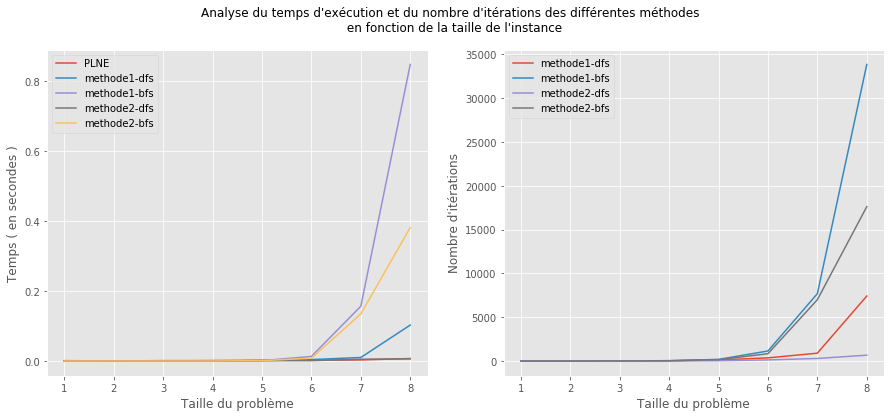

In [62]:
#differentes tailles d'instance pour les tests
val=[i for i in range(1,9)]

#liste pour sauvegarder tps d'execution et nb iterations
t_plne=[] ;t_m1_dfs=[] ; t_m1_bfs=[] ; t_m2_dfs=[] ; t_m2_bfs=[]


for n in val:
    print("taille instance = ",n,"test égalite valeur optimale : ", end="")
    probleme = Ordonnancement()
    probleme.problemeAleatoire(n)
    
    #Resolution PLNE
    t1_plne = time.time()
    probleme.resolutionPLNE(afficheTout=0)
    t_plne.append(time.time()-t1_plne)
    
    #Methode 1 avec un parcours en profondeur (DFS):
    t1_bb1 = time.time()
    z1,x1,k1 = branch_and_bound(probleme,primale1,borne_duale1,Branchement1,depth_first_method)
    print(" z1 = ",z1,end="")
    t_m1_dfs.append([time.time()-t1_bb1,k1])


    #Methode 1 avec un parcours en largeur (BFS):
    t1_bb2 = time.time()
    z2,x2,k2 = branch_and_bound(probleme,primale1,borne_duale1,Branchement1,breadth_first_method)
    print(" z2 = ",z2,end="")
    t_m1_bfs.append([time.time()-t1_bb2,k2])


    #Methode 2 avec un parcours en profondeur (DFS):
    t1_bb3 = time.time()
    z3,x3,k3 = branch_and_bound(probleme,primale1,borne_duale2,Branchement2,depth_first_method)
    print(" z3 = ",z3,end="")
    t_m2_dfs.append([time.time()-t1_bb3,k3])


    #Methode 2 avec un parcours en largeur (BFS):
    t1_bb4 = time.time()
    z4,x4,k4 = branch_and_bound(probleme,primale1,borne_duale2,Branchement2,breadth_first_method)
    print(" z4 = ",z4)
    t_m2_bfs.append([time.time()-t1_bb4,k4])


#affichage resultats
plt.figure(figsize=(15,6))
plt.suptitle("Analyse du temps d'exécution et du nombre d'itérations des différentes méthodes \n en fonction de la taille de l'instance")

label=["methode1-dfs","methode1-bfs","methode2-dfs","methode2-bfs"]
plt.subplot(121)
plt.plot(val,t_plne,label="PLNE")
for t,l in zip([t_m1_dfs,t_m1_bfs,t_m2_dfs,t_m2_bfs],label):
    plt.plot(val,[z[0] for z in t],label=l)
plt.ylabel("Temps ( en secondes )")
plt.xlabel("Taille du problème")
plt.legend()
    
plt.subplot(122)
for (t,l) in zip([t_m1_dfs,t_m1_bfs,t_m2_dfs,t_m2_bfs],label):
    plt.plot(val,[z[1] for z in t],label=l)
plt.ylabel("Nombre d'itérations")
plt.xlabel("Taille du problème")
plt.legend()

plt.show()

Premièrement, nous observons que toutes nos méthodes nous donnent la même valeur optimale de la fonction objective pour les différentes tailles du problème. Nous pouvons donc valider le fonctionnement des différentes méthodes.

Deuxièment, nous observons que la méthode d'exploration influe énormément sur le temps d'exécution. En effet, nous observons que les 2 méthodes les plus lentes et dont les temps d'exécution explosent sont les méthodes 1 et 2 avec un parcours en largeur ( nous nous sommes arêtés à 8 produits sinon le temps d'exécution explose et peut prendre aux alentours de 5 minutes ). A l'inverse, pour 8 produits, les temps d'exécution des méthodes 1 et 2 avec un parcours en profondeur restent faibles, elles vont aussi voir plus vite que la résolution par le modèle PLNE. 

Cette différence sur les temps d'exécution s'explique par le nombre de noeuds visités. En effet, le nombre de noeud visités est égale au nombre d'itérations et nous observons que celui-ci augmente de la même manière que le temps d'exécution. 

Dans le cas des parcours en largeur, le nombre de noeuds visités est très grand. Ceci peut s'expliquer par le fait que la borne primale initiale n'est pas bonne. Par conséquent, l'algorithme de B&B doit atteindre un noeud fils afin d'essayer d'obtenir une meilleure borne primale. Malheureusement, dans le cas d'un parcours en largeur, l'algorithme de B&B doit tout d'abord visiter les noeuds de tous les autres niveaux avant d'atteindre le dernier niveau avec les noeuds fils et donc obtenir une meilleure borne primale.

Par conséquent, notre objectif afin d'obtenir de meilleurs résultats va être de développer des techniques donnant de meilleures bornes primales initiales. Nous allons aussi tenter d'utiliser d'autres méthodes d'exploration qui permettraient d'élaguer plus de noeuds et donc de diminuer le nombre d'itérations.

### c) Nouvelles méthodes de parcours

Comme nous l'avons expliqué dans la partie suivante, afin de diminuer le nombre de noeuds visités, nous pouvons essayer d'autres méthodes d'exploration. Dans notre cas, nous allons en utiliser 2 autres.

Premièrement, nous allons nous intéresser à la méthode d'exploration du meilleur d'abord. Cette méthode consiste à calculer la borne duale de chaque noeud lors de sa création puis de traiter le noeud avec la plus petite borne duale.

Afin de trier les noeuds dans l'ordre croissant des valeurs des bornes duales, nous allons utiliser un tas min binaire. Cette structure de données permet de récupérer le plus petit élement d'une liste en **O(1)**.

La méthode d'exploration du meilleur d'abord prend les mêmes paramètres que les autres méthodes d'exploration en rajoutant **borne_duale** afin de calculer la valeur de la borne duale lors de sa création et **instance** dont nous avons besoin pour calculer la borne duale. 

Son fonctionnement est très similaire, la seule différence se trouve au niveau la liste des indices non traités. En effet, cette fois-ci, nous travaillons avec un tas min binaire donc nous utilisons les méthodes associées au tas min binaire. De plus, nous devons stocker les informations renvoyées par la méthode de calcul de la borne duale. Pour cela, nous les mettons en paramètres supplémentaires dans le tas min binaire

Voici l'implémentation de la méthode d'exploration meilleur d'abord en python : 

In [63]:
def best_first_method(arbre,list_nodes,borne_duale,instance):
    n=len(list_nodes)
    arbre.nombre_noeuds+=n
    arbre.nombre_noeuds_non_traites+=n
    arbre.noeuds += list_nodes
    for i in range(arbre.nombre_noeuds-n,arbre.nombre_noeuds):
        zD, isOptimal, solution  = borne_duale(arbre.noeuds[i],instance)
        heappush(arbre.indice_noeuds_non_traites,(zD,isOptimal,solution,i))

Par la suite, afin d'utiliser cette méthode d'exploration avec l'algorithme de B&B, nous allons devoir modifier les méthodes **recuperationNoeud** et **exploration**. Cependant, nous allons d'abord vous présenter une autre méthode d'exploration puis modifier les 2 méthodes nommées ci-dessus.

La deuxième méthode d'exploration est un mix entre 2 méthodes : exploration en profondeur et meilleur d'abord. En effet, l'objectif de cette méthode est d'effectuer premièrement une exploration en profondeur de l'arbre afin de trouver une bonne borne primale puis d'effectuer la méthode du meilleur d'abord avec cette nouvelle borne primale.

Afin de l'implémenter, nous devons tout d'abord rajouter un nouveau paramètre à la classe **ArbreEnumeration**. Il correspond à une variable booléenne qui indique si oui ou non il y a deja eu une modification de la borne primale, c'est à dire si nous avons déjà atteint un noeud fils avec une meilleure borne primale que la borne primale initiale. Nous le nommons : **first_update_primal**.

Voici la modification dans la classe **ArbreEnumeration** : 

In [64]:
class ArbreEnumeration:
    
    def __init__(self,p1):
            self.nombre_noeuds=1
            self.nombre_noeuds_non_traites = 1
            self.noeuds = [Noeud("Problème initiale",False)]
            self.first_update_primal = False
            self.indice_noeuds_non_traites= [0]
            self.primal_bound=p1

Par la suite, nous pouvons maintenant définir cette méthode d'exploration mixte. Elle prend les mêmes paramètres que la méthode d'exploration meilleur d'abord. Son fonctionnement est séparé en 2 parties. Nous commencons par un parcours en profondeur avec une légère modification : nous calculons déjà la borne duale et nous stockons les informations de la borne duale avec l'indice associées dans la liste des indices des noeuds non traités. Cela permet par la suite de passer à la méthode du meilleur d'abord et donc lors de la première modification, nous pouvons créer le tas minimum binaire puis travailler avec celui-ci lors des itérations suivantes. 

Voici l'implémentation de la méthode **mixed_method** en python : 

In [65]:
def mixed_method(arbre,list_nodes,borne_duale,instance):
    #parcours en profondeur
    if(not arbre.first_update_primal):
        mixed_method.cpt=0 #compteur qui permet de savoir le nombre d'iteration avec la methode meilleur d'abord
        n=len(list_nodes)
        arbre.nombre_noeuds+=n
        arbre.nombre_noeuds_non_traites+=n
        arbre.noeuds += list_nodes
        for i in range(arbre.nombre_noeuds-n,arbre.nombre_noeuds):
            zD, isOptimal, solution  = borne_duale(arbre.noeuds[i],instance)
            arbre.indice_noeuds_non_traites.append((zD,isOptimal,solution,i))
    else:
        mixed_method.cpt+=1
        #transformation de la liste en tas min binaire
        if(mixed_method.cpt==1):
            heapify(arbre.indice_noeuds_non_traites)

        #methode meilleur d'abord
        n=len(list_nodes)
        arbre.nombre_noeuds+=n
        arbre.nombre_noeuds_non_traites+=n
        arbre.noeuds += list_nodes
        for i in range(arbre.nombre_noeuds-n,arbre.nombre_noeuds):
            zD, isOptimal, solution  = borne_duale(arbre.noeuds[i],instance)
            heappush(arbre.indice_noeuds_non_traites,(zD,isOptimal,solution,i))

Nous avons donc défini 2 nouvelles méthodes d'exploration, nous devons maintenant modifier les méthodes **exploration** et **recuperationNoeud**. 

Commencons par **exploration**. La modification est simple. La seule différence est au niveau des paramètres pris en entrée pour les méthodes d'exploration. En effet, les 2 nouvelles méthodes ont 2 paramètres de plus qui sont **borne_duale** et **instance**. 

Ainsi, voici la nouvelle méthode exploration : 

In [66]:
def exploration(explo,arbre,list_nodes,borne_duale,instance):
    if(explo not in [best_first_method,mixed_method]):
        explo(arbre,list_nodes)
    else:
        explo(arbre,list_nodes,borne_duale,instance)

Comme les paramètres de la méthode exploration ne sont pas les même, nous devons modifier modifier l'algorithme de B&B en modifiant seulement la signature de la méthode d'exploration : 

In [67]:
#Algorithme du branch-and-bound:
def branch_and_bound(instance,primale,borne_duale,Branchement,explo):
    
    #Calcul de la borne primale initiale et itialisation de la meilleure solution courante:
    p, Current_best_solution = primale(instance)
    
    #Creation de l'arrbre d'enumeration:
    arbre=ArbreEnumeration(p) 
    
    #Variable comptant le nombre d'iterations
    k = 1
    
    #Boucle principale
    while(arbre.indice_noeuds_non_traites != []):
        #Recuperation du premier noeud Pk dans Q et de la borne duale du probleme associe
        Pk, zD, isOptimal, solution = recuperationNoeud(arbre,explo,k,borne_duale,instance)
        
        #Disjonction des cas:
        if(zD >= arbre.primal_bound):
            #Si zD est plus grand que la borne primale courante, on elague (uniquement pour un probleme de minimisation)
            pass
        elif(isOptimal):
            #Si zD est optimale pour Pk, on met a jour la borne primale:
            if zD < arbre.primal_bound:
                #On met a jour la meilleure solution courante:
                Current_best_solution = solution
                arbre.primal_bound = zD
                arbre.first_update_primal = True
        else:
            #Sinon branchement et ajout des noeuds fils a l'arbre (en fonction de la methode d'exploration):
            list_nodes=Branchement(arbre,instance,Pk)
            exploration(explo,arbre,list_nodes,borne_duale,instance)
        k+=1
    return arbre.primal_bound, Current_best_solution, k

Pour **recuperationNoeud** , il y a 2 modifications. 

Premièrement, cette fois-ci, indice_noeuds_non_traites ne contient pas que les indices mais aussi les informations retournées par la méthode de calcul de la borne duale. Nous devons donc récupérer toutes ces informations. De plus, dans certains cas , nous travaillons avec un tas min binaire, par conséquent, nous n'utilisons pas les mêmes méthodes pour recupérer le noeud à traiter. Il faut aussi diiférencier le cas de la première itération. En effet, dans ce cas, nous récupérons seulement l'indice du noeud à traiter, le noeud racine.

Deuxièmement, nous n'avons cette fois pas besoin de calculer la borne duale pour les nouvelles méthodes. En effet, celles-ci ont déjà été calculées lors de la création des noeuds. Nous devons encore différencier le cas de la première itération. En effet, lors de la première itération nous récupérons que l'indice du noeud, nous devons donc calculer la borne duale.

Voici la nouvelle implémentation de **recuperationNoeud** en python : 

In [68]:
def recuperationNoeud(arbre,explo,k,borne_duale,instance):
    #methode meilleur d'abord
    if(explo == best_first_method):
            Pk = heappop(arbre.indice_noeuds_non_traites)
            if(k!=1):
                zD=Pk[0] ; isOptimal=Pk[1] ; solution=Pk[2] ; Pk=Pk[3]
    #methode mixte
    elif(explo == mixed_method):
        if(arbre.first_update_primal):
            Pk = heappop(arbre.indice_noeuds_non_traites)
            if(k!=1):
                zD=Pk[0] ; isOptimal=Pk[1] ; solution=Pk[2] ; Pk=Pk[3]
        else:
          Pk = arbre.indice_noeuds_non_traites.pop() 
          if(k!=1):
                zD=Pk[0] ; isOptimal=Pk[1] ; solution=Pk[2] ; Pk=Pk[3]
    #autres methode d'exploration
    else:
        Pk = arbre.indice_noeuds_non_traites.pop()

    arbre.nombre_noeuds_non_traites-=1
    
    #Calcul de la borne dual de Pk
    if(explo not in [best_first_method,mixed_method] or k==1):
        zD, isOptimal, solution  = borne_duale(arbre.noeuds[Pk],instance)
    #isOptimal == pos du noeud
    #Zd c'est le premier element de heapop
    return Pk, zD, isOptimal, solution

Nous avons maintenant terminé de rédéfinir les éléments dont nous avons besoin afin d'implémenter nos 2 nouvelles méthodes d'exploration. Par conséquent, comme avec les précédentes méthodes, nous allons les tester sur l'exemple simple du problème traité dans les parties précédentes avec les méthodes 1 et 2. 

![title](img/Exemple.PNG)

Voici nos résultats : 

In [69]:
#Resolution PLNE
t1_plne = time.time()
Exemple.resolutionPLNE()
t2_plne = time.time()
print("Temps exécution pulp: ",t2_plne-t1_plne,"s")

#Methode 1 avec meilleur d'abord :
t1_bb1 = time.time()
z1,x1,k1 = branch_and_bound(Exemple,primale1,borne_duale1,Branchement1,best_first_method)
t2_bb1 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 1 ( Meilleur d'abord ) : \n\nz = ",z1,", x = ",x1)
print("Temps exécution B&B: ",t2_bb1-t1_bb1,"s")
print("Nombre d'itérations: ",k1)

#Methode 1 avec methode mixte:
t1_bb2 = time.time()
z2,x2,k2 = branch_and_bound(Exemple,primale1,borne_duale1,Branchement1,mixed_method)
t2_bb2 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 1 ( Méthode mixte ) : \n\nz = ",z2,", x = ",x2)
print("Temps exécution B&B: ",t2_bb2-t1_bb2,"s")
print("Nombre d'itérations: ",k2)

#Methode 2 avec meilleur d'abord:
t1_bb3 = time.time()
z3,x3,k3 = branch_and_bound(Exemple,primale1,borne_duale2,Branchement2,best_first_method)
t2_bb3 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 2 ( Meilleur d'abord ) : \n\nz = ",z3,", x = ",x3)
print("Temps exécution B&B: ",t2_bb3-t1_bb3,"s")
print("Nombre d'itérations: ",k3)

#Methode 2 avec la methode mixte:
t1_bb4 = time.time()
z4,x4,k4 = branch_and_bound(Exemple,primale1,borne_duale2,Branchement2,mixed_method)
t2_bb4 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 2 ( Méthode mixte ) : \n\nz = ",z4,", x = ",x4)
print("Temps exécution B&B: ",t2_bb4-t1_bb4,"s")
print("Nombre d'itérations: ",k4)


SOLUTION OBTENUE PLNE:

Solve with CBC, Status: Optimal
Total des pénalités: 67.0
Ordre d'usinage des pièces: [0, 1, 3, 2]
Temps exécution pulp:  0.042932987213134766 s


SOLUTION OBTENUE B&B METHODE 1 ( Meilleur d'abord ) : 

z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.0 s
Nombre d'itérations:  24


SOLUTION OBTENUE B&B METHODE 1 ( Méthode mixte ) : 

z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.000997304916381836 s
Nombre d'itérations:  28


SOLUTION OBTENUE B&B METHODE 2 ( Meilleur d'abord ) : 

z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.0 s
Nombre d'itérations:  11


SOLUTION OBTENUE B&B METHODE 2 ( Méthode mixte ) : 

z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.0 s
Nombre d'itérations:  14


Nous remarquons que les 2 nouvelles méthodes d'exploration associées aux méthodes 1 et 2 donnent la bonne valeur optimale. Nos méthodes d'exploration ont donc l'air de fonctionner. Nous allons maintenant regarder si elles permettent d'accélérer l'éxécution de l'algorithme de B&B. Pour cela, nous allons comparer le temps d'exécution et le nombre d'itérations des méthodes de parcours DFS, meilleur d'abord et la méthode mixte avec les méthodes 1 et 2 de branchement. Nous allons aussi comparer leurs valeurs optimales afin de tester leurs validités.

Pour réaliser notre expérience, nous allons utiliser des tailles d'instance allant de 1 à 9 produits. Ci-dessous, voici le code utilisé afin de réaliser l'expérience et nos résultats :

taille instance =  1 test égalite valeur optimale :  z1 =  0 z2 =  0 z3 =  0 z4 =  0 z5 =  0 z6 =  0
taille instance =  2 test égalite valeur optimale :  z1 =  0 z2 =  0 z3 =  0 z4 =  0 z5 =  0 z6 =  0
taille instance =  3 test égalite valeur optimale :  z1 =  12 z2 =  12 z3 =  12 z4 =  12 z5 =  12 z6 =  12
taille instance =  4 test égalite valeur optimale :  z1 =  38 z2 =  38 z3 =  38 z4 =  38 z5 =  38 z6 =  38
taille instance =  5 test égalite valeur optimale :  z1 =  14 z2 =  14 z3 =  14 z4 =  14 z5 =  14 z6 =  14
taille instance =  6 test égalite valeur optimale :  z1 =  70 z2 =  70 z3 =  70 z4 =  70 z5 =  70 z6 =  70
taille instance =  7 test égalite valeur optimale :  z1 =  0 z2 =  0 z3 =  0 z4 =  0 z5 =  0 z6 =  0
taille instance =  8 test égalite valeur optimale :  z1 =  325 z2 =  325 z3 =  325 z4 =  325 z5 =  325 z6 =  325
taille instance =  9 test égalite valeur optimale :  z1 =  868 z2 =  868 z3 =  868 z4 =  868 z5 =  868 z6 =  868


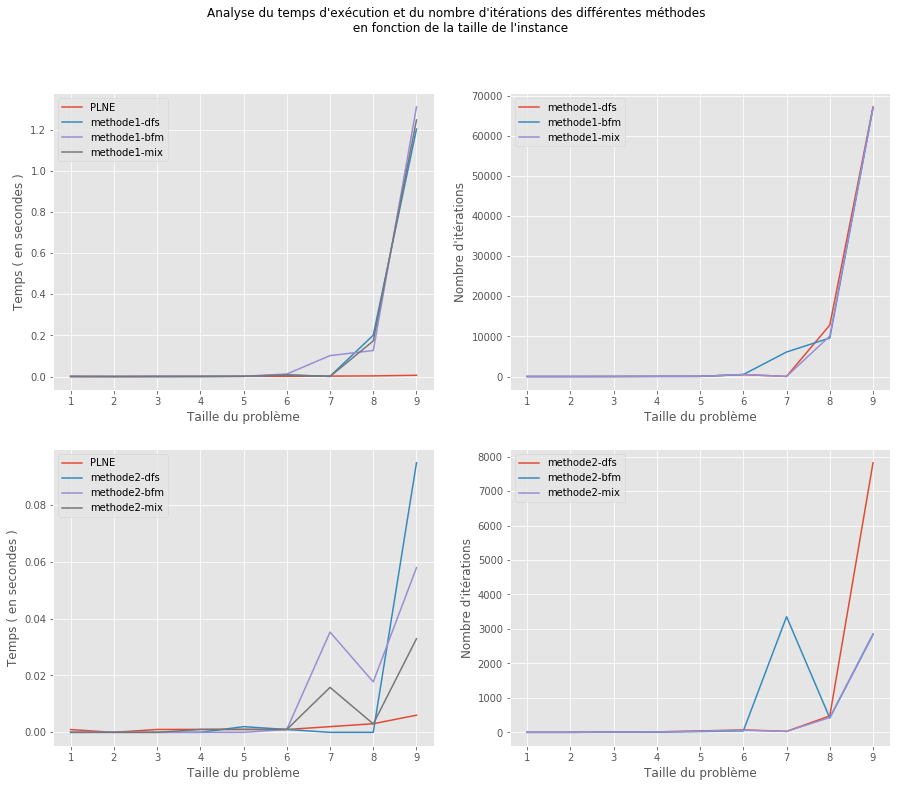

In [70]:
#differentes tailles d'instance pour les tests
val=[i for i in range(1,10)]

#liste pour sauvegarder tps d'execution et nb iterations
t_plne=[] ;t_m1_dfs=[] ; t_m1_bfm=[] ; t_m1_mix=[] ;  t_m2_dfs=[] ; t_m2_bfm=[] ; t_m2_mix=[] 


for n in val:
    print("taille instance = ",n,"test égalite valeur optimale : ", end="")
    probleme = Ordonnancement()
    probleme.problemeAleatoire(n)
    
    #Resolution PLNE
    t1_plne = time.time()
    probleme.resolutionPLNE(afficheTout=0)
    t_plne.append(time.time()-t1_plne)
    
    #Methode 1 avec un parcours en profondeur (DFS):
    t1_bb1 = time.time()
    z1,x1,k1 = branch_and_bound(probleme,primale1,borne_duale1,Branchement1,depth_first_method)
    print(" z1 = ",z1,end="")
    t_m1_dfs.append([time.time()-t1_bb1,k1])


    #Methode 1 avec meilleur d'abord (BFM):
    t1_bb2 = time.time()
    z2,x2,k2 = branch_and_bound(probleme,primale1,borne_duale1,Branchement1,best_first_method)
    print(" z2 = ",z2,end="")
    t_m1_bfm.append([time.time()-t1_bb2,k2])
    
    #Methode 1 avec la méthode mixte:
    t1_bb3 = time.time()
    z3,x3,k3 = branch_and_bound(probleme,primale1,borne_duale1,Branchement1,mixed_method)
    print(" z3 = ",z3,end="")
    t_m1_mix.append([time.time()-t1_bb3,k3])


    #Methode 2 avec un parcours en profondeur (DFS):
    t1_bb4 = time.time()
    z4,x4,k4 = branch_and_bound(probleme,primale1,borne_duale2,Branchement2,depth_first_method)
    print(" z4 = ",z4,end="")
    t_m2_dfs.append([time.time()-t1_bb4,k4])


    #Methode 2 avec meilleur d'abord:
    t1_bb5 = time.time()
    z5,x5,k5 = branch_and_bound(probleme,primale1,borne_duale2,Branchement2,best_first_method)
    print(" z5 = ",z5,end="")
    t_m2_bfm.append([time.time()-t1_bb5,k5])
    
    #Methode 2 avec un méthode mixte:
    t1_bb6 = time.time()
    z6,x6,k6 = branch_and_bound(probleme,primale1,borne_duale2,Branchement2,mixed_method)
    print(" z6 = ",z6)
    t_m2_mix.append([time.time()-t1_bb6,k6])


#affichage resultats
plt.figure(figsize=(15,12))
plt.suptitle("Analyse du temps d'exécution et du nombre d'itérations des différentes méthodes \n en fonction de la taille de l'instance")

label=["methode1-dfs","methode1-bfm","methode1-mix"]
plt.subplot(221)
plt.plot(val,t_plne,label="PLNE")
for t,l in zip([t_m1_dfs,t_m1_bfm,t_m1_mix],label):
    plt.plot(val,[z[0] for z in t],label=l)
plt.ylabel("Temps ( en secondes )")
plt.xlabel("Taille du problème")
plt.legend()
    
plt.subplot(222)
for (t,l) in zip([t_m1_dfs,t_m1_bfm,t_m1_mix],label):
    plt.plot(val,[z[1] for z in t],label=l)
plt.ylabel("Nombre d'itérations")
plt.xlabel("Taille du problème")
plt.legend()

label=["methode2-dfs","methode2-bfm","methode2-mix"]
plt.subplot(223)
plt.plot(val,t_plne,label="PLNE")
for t,l in zip([t_m2_dfs,t_m2_bfm,t_m2_mix],label):
    plt.plot(val,[z[0] for z in t],label=l)
plt.ylabel("Temps ( en secondes )")
plt.xlabel("Taille du problème")
plt.legend()
    
plt.subplot(224)
for (t,l) in zip([t_m2_dfs,t_m2_bfm,t_m2_mix],label):
    plt.plot(val,[z[1] for z in t],label=l)
plt.ylabel("Nombre d'itérations")
plt.xlabel("Taille du problème")
plt.legend()


plt.show()

Premièrement, nous remarquons que les valeurs optimales sont toutes les mêmes, nous pouvons donc valider le fonctionnement des 2 nouvelles méthodes de parcours.

Deuxièmement, nous remarquons que les temps d'exécution des nouvelles méthodes d'exploration sont proches de ceux du parcours en profondeur et varient en fonction des instances. Néanmoins, le nombre d'itérations diminue un peu pour les 2 nouvelles méthodes, même si la baisse est légère. Cette baisse du nombre d'itérations devrait baisser le temps d'exécution pour des instances plus grandes. Nous analyserons plus précisement les méthodes plus tard.

Enfin, nous pouvons observer que la méthode 2 est beaucoup plus rapide que la méthode 1. En effet, par exemple, avec l'instance avec 9 produits, le temps d'exécution est plus de 2 fois moins long avec la méthode 2. Nous observons le même phénomène pour le nombre d'itérations.

Afin d'améliorer nos méthodes, il peut être intéressant d'obtenir de meilleure borne primale initiale afin de continuer à diminuer le nombre d'itérations. Nous allons donc voir comment en obtenir dans la prochaine méthode.

### d) Nouvelles méthodes pour les bornes primales

Jusqu'ici, nous avons implémenté une méthode naïve pour le calcul de la borne primale initiale qui consistait simplement à prendre la solution réalisable correspondant à l'usinage des pièces dans l'ordre croissant de leurs indices. Selon les instances traitées, cette solution peut produire ou non une 'bonne' borne primale initiale (c'est-à-dire une borne qui va permettre d'élaguer très tôt le plus de noeuds possibles).\
Une autre solution consisterait à ranger les pièces dans l'ordre croissant de leur dates limites $d_j$ (leurs deadlines). Par exemple, pour l'exemple présenté en introduction, l'ordre des pièces selon les dates limites croissantes serait : $0$, $2$, $1$ et $3$ et donc la solution réalisable obtenue serait $P_{0,\,2,\, 1,\, 3}$. Cette méthode n'est pas toujours plus avantageuse, notamment sur l'exemple, la méthode 1 utilisée jusqu'ici fournit comme borne primale initiale la valeur de la solution de $P_{0,\,1,\,2,\,3}$ qui est de $115$ tandis que la méthode proposée ici fournit comme borne primale initiale la valeur de $P_{0,\,2,\, 1,\, 3}$ qui n'est que de $136$.\
Nous avons implémenté cette technique dans la fonction primale2 qui prend en paramètre une instance du problème **instance** et qui retourne la valeur de la borne primale (**primale**) ainsi que la solution associée.

In [71]:
def primale2(instance):
    borne = 0
    tuples_indice_deadline = [(i,instance.deadlines[i]) for i in range(instance.nb_piece)]
    tuples_indice_deadline = sorted(tuples_indice_deadline, key=itemgetter(1))
    solution = [tuples_indice_deadline[i][0] for i in range(instance.nb_piece)]
    date_fin = 0
    for i in solution:
        date_fin += instance.unite_temps[i]
        borne += max(0,date_fin - instance.deadlines[i])*instance.penalites[i]
    return(borne, solution)

Cependant cette méthode ci-dessus (ainsi que la première) ne tient pas compte des pénalités de retard des pièces. En effet, ici on ne se base que sur la date limite de chaque pièce mais il est tout à fait possible qu'une pièce ai une grande deadline $d_j$ tout en ayant une grande valeur de pénalité de retard par unité de temps $\omega_j$, auquel cas cette pièce peut finalement engendrée beaucoup de pénalité bien que sa date limite soit tardive. Sur l'exemple de base, la pièce 2 doit être prête avant la pièce 3 (on a $d_2 = 25 < d_3 = 27$) donc si on suit la méthode présentée ci-dessus, on devrait ranger la pièce 2 avant la pièce 3 mais si la pièce 2 passait en dernier, elle n'engendrerait une pénalité que de $\max(0,\sum_{j=0}^3{T_j} - d_2)\times \omega_2 = 57$ tandis que si la pièce 3 passait en dernier, elle engendrerait une pénalité de $\max(0,\sum_{j=0}^3{T_j} - d_3)\times \omega_3 = 85$. Une autre méthode permettant d'obtenir une borne primale initiale consisterait à prendre en compte le retard potentiel que peut engendrer chaque pièce. On crée donc une solution en ajoutant successivement en dernière position (en partant de la fin) la pièce qui si elle est usiné en dernière position disponible engendrera la plus petite pénalité. Reprenons l'exemple donné en introduction, la pièce donnant lieu à la plus petite pénalité de retard en dernière position est la pièce 2 avec une pénalité de $\max(0,\sum_{j=0}^3{T_j} - d_2)\times \omega_2 = 57$. Ensuite la pièce donnant lieu à la plus petite pénalité de retard en avant-dernière position est la pièce 3 avec une péanlité de $\max(0,\sum_{ j\in J\backslash \{2\}  }{T_j} - d_3)\times \omega_3 = 10$ et ainsi de suite. Pour l'exemple considéré on obtient la solution associée à $P_{0,\,1,\,3,\,2}$ dont la valeur est de $67$ (Notons ici que l'on tombe sur la solution optimale de l'instance).

Cette nouvelle méthode de calcul de la borne primale initiale a été implémenté dans la fonction primale3 qui suit le même modèle que les fonctions primale1 et primale2 en prenant en paramètre une instance du problème **instance** et qui retourne la valeur de la borne primale (**primale**) ainsi que la solution associée.

In [72]:
def primale3(instance):
    borne = 0
    piece_non_ajoute = list(range(instance.nb_piece))
    solution = []
    date_fin = sum(instance.unite_temps)
    while(len(piece_non_ajoute) != 0):
        pire_cas = [ max(0,(date_fin - instance.deadlines[i]))*instance.penalites[i] for i in piece_non_ajoute ]
        index = np.argmin(pire_cas)
        borne += pire_cas[index]
        prochaine_piece = piece_non_ajoute.pop(index)
        date_fin -= instance.unite_temps[prochaine_piece]
        solution.insert(0,prochaine_piece)
    return(borne,solution)

Calculons maintenant une borne primale (intiale)sur l'exemple avec les 3 méthodes dont nous disposons maintenant.

In [73]:
object1 = primale1(Exemple)
print("- Méthode primale1 pour l'exemple donné en introduction : ")
print("Borne primale initiale: ",str(object1[0]),", Solution réalisable correspondante: ",str(object1[1]))
object2 = primale2(Exemple)
print("- Méthode primale2 pour l'exemple donné en introduction : ")
print("Borne primale initiale: ",str(object2[0]),", Solution réalisable correspondante: ",str(object2[1]))
object3 = primale3(Exemple)
print("- Méthode primale3 pour l'exemple donné en introduction : ")
print("Borne primale initiale: ",str(object3[0]),", Solution réalisable correspondante: ",str(object3[1]))

- Méthode primale1 pour l'exemple donné en introduction : 
Borne primale initiale:  115 , Solution réalisable correspondante:  [0, 1, 2, 3]
- Méthode primale2 pour l'exemple donné en introduction : 
Borne primale initiale:  136 , Solution réalisable correspondante:  [0, 2, 1, 3]
- Méthode primale3 pour l'exemple donné en introduction : 
Borne primale initiale:  67 , Solution réalisable correspondante:  [0, 1, 3, 2]


On remarque que l'on obtient bien les valeurs et les solutions citées précédemment.

Nous disposons maintenant de 3 méthodes fonctionnelles permettant de calculer une borne primale initiale pour une instance du problème d'ordonnancement. Cependant, il est assez difficile de comparer ces méthodes entres elles et d'en dégager une qui serait siginificativement meilleur que les autres. En effet, bien que les fonctions primale2 et primale3 semblent fournir des bornes primales initiales avec des techniques plus élaborées que celle de la fonction primale1, il est tout à fait possible que pour certaines instances la fonction primale1 produise une meilleure borne primale (qui aboutira à un "meilleure" élagage de l'arbre d'énumération) initiale que les 2 autres fonctions (en effet, pour une instance de taille $n$, la solution de $P_{0,\,...,\,n}$ donnée par primale1 peut très bien être une très bonne borne primale proche de la solution du problème).

Dans notre cas, pour mettre en évidence l'impact du choix de la borne primale initiale sur l'éxecution de l'algorithme de Branch-and-bound, nous allons utiliser les 2 fonctions suivantes permettant de produire des bornes primales initiales.

In [74]:
#Fonction renvoyant la pire borne primale (la plus grande) parmi primale1, primale2 et primale3 pour une instance donnee
def primale_worst(instance):
    tuple_primale =(primale1(instance),primale2(instance),primale3(instance))
    best_primale = max(tuple_primale)
    return(best_primale[0],best_primale[1])

#Fonction renvoyant la meilleure borne primale (la plus petite) parmi primale1, primale2 et primale3 pour une instance donnee
def primale_best(instance):
    tuple_primale =(primale1(instance),primale2(instance),primale3(instance))
    best_primale = min(tuple_primale)
    return(best_primale[0],best_primale[1])

La première fonction renvoie la plus grande borne primale calculée par primale1, primale2 et primale3 pour une instance donnée tandis que la deuxième fonction renvoie la plus petite borne primale calculée par primale1, primale2 et primale3 toujours pour une instance donnée.

Sur des instances aléatoires de taille croissante, nous allons comparer pour différentes méthodes implémentées précédemment l'éxécution de l'algorithme de Branch-and-Bound lorsqu'il est initialisé avec la pire borne primale des 3 fonctions (primale1, primale2 et primale3) et lorsqu'il est initialisé avec la meilleure borne primale des 3 fonctions. Nous nous attendons à ce que ceci mette en évidence le fait qu'une mauvaise borne (trop grande) puisse dans certaines cas engendrer des temps d'éxecution beaucoup plus longs. 

Nous avons constaté précédement que l'utilisation d'un parcours en largeur comme méthode d'exploration pouvait engendrer des temps d'exécution très longs et nous avons supposé que ceci provenait du fait que la borne primale initiale était de mauvaise qualité. Comparons donc l'exécution de l'algorithme de Branch-and-bound pour la méthode 1 avec un parcours en largeur en guise de méthode d'exploration dans le cas où l'algorithme est systématiquement initialisé avec la pire borne primale des 3 fonctions et dans le cas où il est systématiquement initialisé avec la meilleure borne primale des 3 fonctions (pour des instances dont la taille varie entre $n=1$ et $n=8$).

taille instance =  1 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  2 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  3 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  4 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  5 test égalite valeur optimale :  z1 =  319 z2 =  319
taille instance =  6 test égalite valeur optimale :  z1 =  16 z2 =  16
taille instance =  7 test égalite valeur optimale :  z1 =  481 z2 =  481
taille instance =  8 test égalite valeur optimale :  z1 =  306 z2 =  306


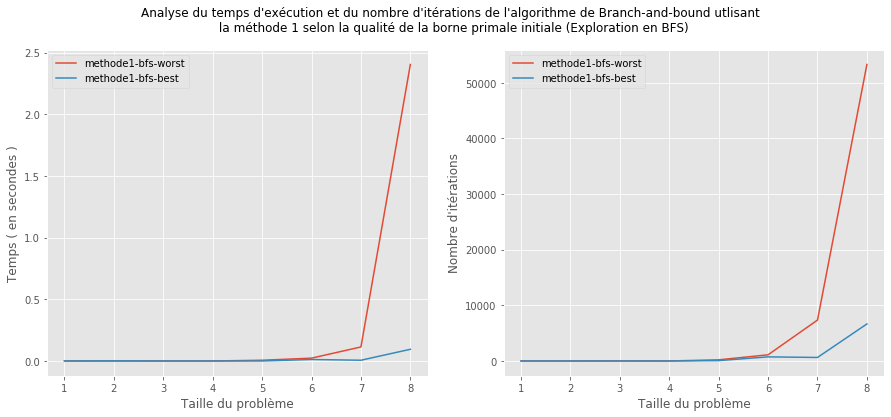

In [75]:
#Avec la méthode 1 (BFS)
val=[i for i in range(1,9)]

t_m1_bfs_best = [] ; t_m1_bfs_worst = []


for n in val:
    print("taille instance = ",n,"test égalite valeur optimale : ", end="")
    probleme = Ordonnancement()
    probleme.problemeAleatoire(n)
    
    #Méthode 1 avec un parcours en largeur (BFS) pour la "pire" méthode:
    t1_bb2 = time.time()
    z1,x1,k1 = branch_and_bound(probleme,primale_worst,borne_duale1,Branchement1,breadth_first_method)
    print(" z1 = ",z1,end="")
    t_m1_bfs_worst.append([time.time()-t1_bb2,k1])
    
    #Méthode 1 avec un parcours en largeur (BFS) pour la "meilleure" méthode:
    t1_bb2 = time.time()
    z2,x2,k2 = branch_and_bound(probleme,primale_best,borne_duale1,Branchement1,breadth_first_method)
    print(" z2 = ",z2,end="")
    t_m1_bfs_best.append([time.time()-t1_bb2,k2])
    print("")
    
#affichage resultats
plt.figure(figsize=(15,6))
plt.suptitle("Analyse du temps d'exécution et du nombre d'itérations de l'algorithme de Branch-and-bound utlisant \n la méthode 1 selon la qualité de la borne primale initiale (Exploration en BFS)")
label=["methode1-bfs-worst","methode1-bfs-best"]
plt.subplot(121)
for t,l in zip([t_m1_bfs_worst,t_m1_bfs_best],label):
    plt.plot(val,[z[0] for z in t],label=l)
plt.ylabel("Temps ( en secondes )")
plt.xlabel("Taille du problème")
plt.legend()
    
plt.subplot(122)
for t,l in zip([t_m1_bfs_worst,t_m1_bfs_best],label):
    plt.plot(val,[z[1] for z in t],label=l)
plt.ylabel("Nombre d'itérations")
plt.xlabel("Taille du problème")
plt.legend()

plt.show()   

Faisons de même en utilisant toujours un parcours en largeur mais cette fois-ci avec la méthode 2.

taille instance =  1 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  2 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  3 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  4 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  5 test égalite valeur optimale :  z1 =  32 z2 =  32
taille instance =  6 test égalite valeur optimale :  z1 =  41 z2 =  41
taille instance =  7 test égalite valeur optimale :  z1 =  851 z2 =  851
taille instance =  8 test égalite valeur optimale :  z1 =  546 z2 =  546


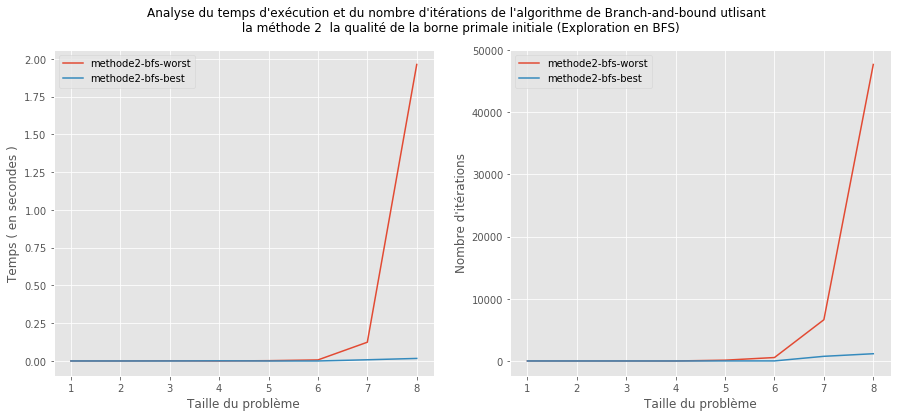

In [76]:
#Avec la méthode 2 (BFS)
val=[i for i in range(1,9)]

t_m2_bfs_worst = [] ; t_m2_bfs_best = []


for n in val:
    print("taille instance = ",n,"test égalite valeur optimale : ", end="")
    probleme = Ordonnancement()
    probleme.problemeAleatoire(n)
    
    #Méthode 2 avec un parcours en largeur (BFS) pour la "pire" méthode:
    t1_bb2 = time.time()
    z1,x1,k1 = branch_and_bound(probleme,primale_worst,borne_duale2,Branchement2,breadth_first_method)
    print(" z1 = ",z1,end="")
    t_m2_bfs_worst.append([time.time()-t1_bb2,k1])
    
    #Méthode 2 avec un parcours en largeur (BFS) pour la "meilleure" méthode:
    t1_bb2 = time.time()
    z2,x2,k2 = branch_and_bound(probleme,primale_best,borne_duale2,Branchement2,breadth_first_method)
    print(" z2 = ",z2,end="")
    t_m2_bfs_best.append([time.time()-t1_bb2,k2])
    print("")
    
#affichage resultats
plt.figure(figsize=(15,6))
plt.suptitle("Analyse du temps d'exécution et du nombre d'itérations de l'algorithme de Branch-and-bound utlisant \n la méthode 2  la qualité de la borne primale initiale (Exploration en BFS)")

label=["methode2-bfs-worst","methode2-bfs-best"]
plt.subplot(121)
for t,l in zip([t_m2_bfs_worst,t_m2_bfs_best],label):
    plt.plot(val,[z[0] for z in t],label=l)
plt.ylabel("Temps ( en secondes )")
plt.xlabel("Taille du problème")
plt.legend()
    
plt.subplot(122)
for t,l in zip([t_m2_bfs_worst,t_m2_bfs_best],label):
    plt.plot(val,[z[1] for z in t],label=l)
plt.ylabel("Nombre d'itérations")
plt.xlabel("Taille du problème")
plt.legend()

plt.show()   

Sur les 2 jeux de graphiques obtenus en sortie, on peut observer que lorsque la taille de l'instance augmente, le temps d'éxecution et le nombre d'itérations de l'algorithme de Branch-and-bound augmente plus fortement lorsqu'il est initialisé systématiquement avec la "pire" borne primale que lorsqu'il est initialisé avec la "meilleure" borne primale. Ceci met donc en évidence le fait que le choix de la borne primale initiale peut être déterminant dans la poursuite de l'exécution de l'algorithme de Branch-and-bound lorsqu'il utilise une méthode de parcours en largeur pour visiter les noeuds de l'arbre.

Regardons maintenant ce qu'il en est lorsque l'on utilise cette fois-ci une méthode de parcours en profondeur pour explorer les noeuds de l'arbre. De la même manière, on compare l'exécution de l'algorithme de Branch-and-bound pour la méthode 1 et pour la méthode 2 avec un parcours en profondeur en guise de méthode d'exploration dans le cas où l'algorithme est systématiquement initialisé avec la pire borne primale des 3 fonctions et dans le cas où il est systématiquement initialisé avec la meilleure borne primale des 3 fonctions (toujours pour des instances dont la taille varie entre $n=1$ et $n=8$).

taille instance =  1 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  2 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  3 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  4 test égalite valeur optimale :  z1 =  1 z2 =  1
taille instance =  5 test égalite valeur optimale :  z1 =  21 z2 =  21
taille instance =  6 test égalite valeur optimale :  z1 =  365 z2 =  365
taille instance =  7 test égalite valeur optimale :  z1 =  114 z2 =  114
taille instance =  8 test égalite valeur optimale :  z1 =  232 z2 =  232


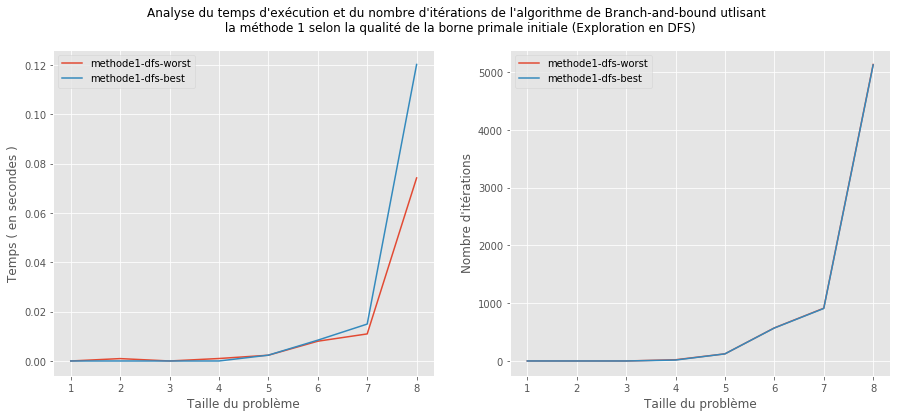

In [77]:
#Avec la methode 1 (DFS)
val=[i for i in range(1,9)]

t_m1_dfs_worst = [] ; t_m1_dfs_best = []


for n in val:
    print("taille instance = ",n,"test égalite valeur optimale : ", end="")
    probleme = Ordonnancement()
    probleme.problemeAleatoire(n)
    
    #Methode 1 avec un parcours en largeur (BFS) pour la "pire" methode:
    t1_bb2 = time.time()
    z1,x1,k1 = branch_and_bound(probleme,primale_worst,borne_duale1,Branchement1,depth_first_method)
    print(" z1 = ",z1,end="")
    t_m1_dfs_worst.append([time.time()-t1_bb2,k1])
    
    #Methode 1 avec un parcours en largeur (BFS) pour la "meilleure" methode:
    t1_bb2 = time.time()
    z2,x2,k2 = branch_and_bound(probleme,primale_best,borne_duale1,Branchement1,depth_first_method)
    print(" z2 = ",z2,end="")
    t_m1_dfs_best.append([time.time()-t1_bb2,k2])
    print("")
    
#affichage resultats
plt.figure(figsize=(15,6))
plt.suptitle("Analyse du temps d'exécution et du nombre d'itérations de l'algorithme de Branch-and-bound utlisant \n la méthode 1 selon la qualité de la borne primale initiale (Exploration en DFS)")

label=["methode1-dfs-worst","methode1-dfs-best"]
plt.subplot(121)
for t,l in zip([t_m1_dfs_worst,t_m1_dfs_best],label):
    plt.plot(val,[z[0] for z in t],label=l)
plt.ylabel("Temps ( en secondes )")
plt.xlabel("Taille du problème")
plt.legend()
    
plt.subplot(122)
for t,l in zip([t_m1_dfs_worst,t_m1_dfs_best],label):
    plt.plot(val,[z[1] for z in t],label=l)
plt.ylabel("Nombre d'itérations")
plt.xlabel("Taille du problème")
plt.legend()

plt.show()   

taille instance =  1 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  2 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  3 test égalite valeur optimale :  z1 =  0 z2 =  0
taille instance =  4 test égalite valeur optimale :  z1 =  240 z2 =  240
taille instance =  5 test égalite valeur optimale :  z1 =  239 z2 =  239
taille instance =  6 test égalite valeur optimale :  z1 =  82 z2 =  82
taille instance =  7 test égalite valeur optimale :  z1 =  239 z2 =  239
taille instance =  8 test égalite valeur optimale :  z1 =  453 z2 =  453


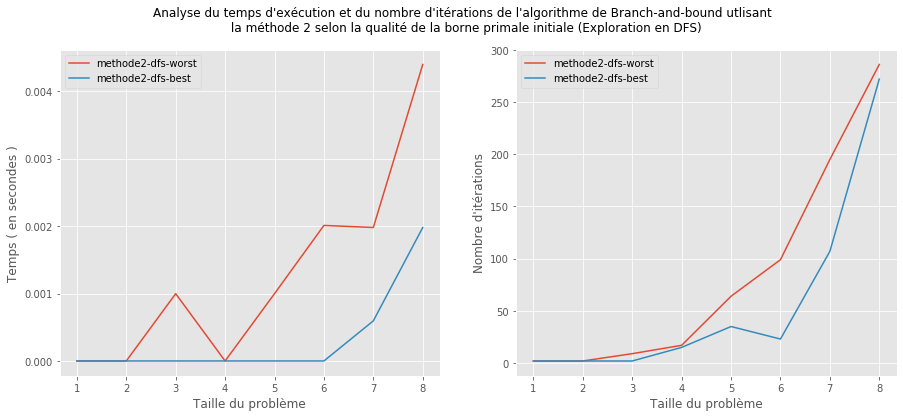

In [78]:
#Avec la methode 2 (DFS)
val=[i for i in range(1,9)]

t_m2_dfs_worst = [] ; t_m2_dfs_best = []


for n in val:
    print("taille instance = ",n,"test égalite valeur optimale : ", end="")
    probleme = Ordonnancement()
    probleme.problemeAleatoire(n)
    
    #Methode 2 avec un parcours en largeur (BFS) pour la "pire" methode:
    t1_bb2 = time.time()
    z1,x1,k1 = branch_and_bound(probleme,primale_worst,borne_duale2,Branchement2,depth_first_method)
    print(" z1 = ",z1,end="")
    t_m2_dfs_worst.append([time.time()-t1_bb2,k1])
    
    #Methode 2 avec un parcours en largeur (BFS) pour la "meilleure" methode:
    t1_bb2 = time.time()
    z2,x2,k2 = branch_and_bound(probleme,primale_best,borne_duale2,Branchement2,depth_first_method)
    print(" z2 = ",z2,end="")
    t_m2_dfs_best.append([time.time()-t1_bb2,k2])
    print("")
    
#affichage resultats
plt.figure(figsize=(15,6))
plt.suptitle("Analyse du temps d'exécution et du nombre d'itérations de l'algorithme de Branch-and-bound utlisant \n la méthode 2 selon la qualité de la borne primale initiale (Exploration en DFS)")

label=["methode2-dfs-worst","methode2-dfs-best"]
plt.subplot(121)
for t,l in zip([t_m2_dfs_worst,t_m2_dfs_best],label):
    plt.plot(val,[z[0] for z in t],label=l)
plt.ylabel("Temps ( en secondes )")
plt.xlabel("Taille du problème")
plt.legend()
    
plt.subplot(122)
for t,l in zip([t_m2_dfs_worst,t_m2_dfs_best],label):
    plt.plot(val,[z[1] for z in t],label=l)
plt.ylabel("Nombre d'itérations")
plt.xlabel("Taille du problème")
plt.legend()

plt.show()  

On remarque cette fois-ci sur les 2 jeux de graphique précédents que l'impact de la qualité de la borne primale initiale est moins élevé sur le temps d'exécution et sur le nombre d'itération de l'algorithme de Branch-and-bound, utilisant en guise de méthode d'exploration un parcours en profondeur de l'arbre d'énumération. En effet, l'utilisation d'un parcours en profondeur permet d'atteindre plus tôt les noeuds feuilles de l'arbre d'énumération et donc la borne primale (qu'elle soit "bonne" ou "mauvaise") sera mise-à-jour très tôt dans l'exécution de l'algorithme. On illustre bien ici le fait que l'exploration de l'arbre d'énumération par un parcours en profondeur permet de trouver rapidement une "bonne" borne primale. 

Nous avons ainsi montré que l'utilisation d'une meilleur borne primale initiale permettait d'accélérer l'exécution de l'algorithme de Branch-and-bound lorsque celui-ci utilise un parcours en largeur comme méthode d'exploration. Cependant, on peut quand même constater que même avec une très bonne borne primale, l'utilisation d'un parcours en largeur ne rivalise pas avec les autres méthodes d'exploration.

### e) Analyse des résultats

Nous allons donc maintenant comparer en détail les performances de notre algorithme de Branch-and-bound pour les différentes configurations que nous avons présenté jusqu'ici. D'abord, nous savons que l'algorithme produit ses performances les moins bonnes lorsqu'il explore l'arbre d'énumération avec un parcours en largeur (et ceci même avec une bonne borne primale initiale). Nous ne nous concentrerons donc uniquement sur les 3 autres méthodes d'exploration (parcours en profondeur, "meilleur d'abord" et mixte). De plus, nous avons jusqu'ici observé des résultats légèrement meilleurs avec la méthode 2, nous allons nous nous concentrer uniquement sur la méthode 2 afin de réduire le nombre de configurations possibles (L'analyse qui va suivre aurait tout à fait pu être faite avec la méthode 1). Nous avons enfin montré que l'impact du choix de la valeur de la borne primale intiale était faible sur l'éxecution de l'algorithme lorsque celui-ci utilisait d'autres méthodes d'exploration que le parcours en largeur mais pour ces tests, nous utiliser systématiquement la fonction primale_best pour trouver une borne primale initiale. Pour des tailles $n$ d'instance croissante (allant de 1 à 11 éléments), nous allons mesurer le temps d'exécution et le nombre d'itérations de l'algorithme sur 10 instance afin d'obtenir une moyenne de ces valeurs. Nous afficherons ensuite graphiquement les résultats.

taille instance =  1
taille instance =  2
taille instance =  3
taille instance =  4
taille instance =  5
taille instance =  6
taille instance =  7
taille instance =  8
taille instance =  9
taille instance =  10
taille instance =  11


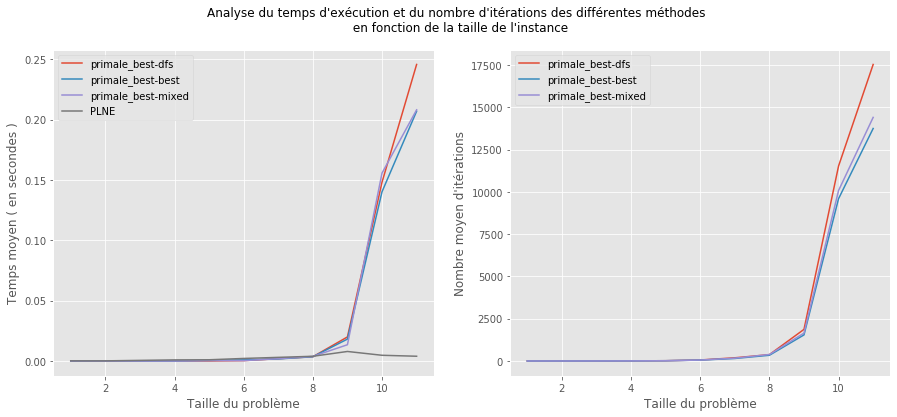

In [79]:
#Valeurs pour les tailles d'instance
val=[i for i in range(1,12)]

#liste pour sauvegarder tps d'execution et nb iterations
t_plne_mean=[] #tps d'execution et nb iterations pour le PLNE
t_dfs_mean_best=[] #tps d'execution et nb iterations pour Methode 2 + DFS + primale_best
t_best_mean_best=[] #tps d'execution et nb iterations pour Methode 2 + "Meilleur d'abord" + primale_best
t_mixed_mean_best=[] #tps d'execution et nb iterations pour Methode 2 + "Mixte" + primale_best

#Taille des echantillons pour la moyenne
M = 10

for n in val:
    print("taille instance = ",n)
     #Creation des liste pour calculer les moyennes 
    t_plne=[] 
    t_dfs_best=[]  ; t_best_best=[] ; t_mixed_best=[]
    for compteur in range(M):
        #Creation d'une instance
        probleme = Ordonnancement()
        probleme.problemeAleatoire(n)
        #Resolution PLNE
        t1_plne = time.time()
        probleme.resolutionPLNE(afficheTout=0)
        t_plne.append(time.time()-t1_plne)

        #Parcours en profondeur (DFS) et primale_best pour methode 2:
        t1_bb1 = time.time()
        z1,x1,k1 = branch_and_bound(probleme,primale_best,borne_duale2,Branchement2,depth_first_method)
        t_dfs_best.append([time.time()-t1_bb1,k1])

        #Methode "meilleur d'abord" et primale_best pour methode 2:
        t1_bb3 = time.time()
        z3,x3,k3 = branch_and_bound(probleme,primale_best,borne_duale2,Branchement2,best_first_method)
        t_best_best.append([time.time()-t1_bb3,k3])

        #Methode mixte et primale_best pour methode 2:
        t1_bb4 = time.time()
        z4,x4,k4 = branch_and_bound(probleme,primale_best,borne_duale2,Branchement2,mixed_method)
        t_mixed_best.append([time.time()-t1_bb4,k4])
        
    t_plne_mean.append(np.mean(t_plne))
    t_dfs_mean_best.append( [np.mean([t_dfs_best[i][0] for i in range(len(t_dfs_best))]),np.mean([t_dfs_best[i][1] for i in range(len(t_dfs_best))])] )
    t_best_mean_best.append( [np.mean([t_best_best[i][0] for i in range(len(t_best_best))]),np.mean([t_best_best[i][1] for i in range(len(t_best_best))])] )
    t_mixed_mean_best.append( [np.mean([t_mixed_best[i][0] for i in range(len(t_mixed_best))]),np.mean([t_mixed_best[i][1] for i in range(len(t_mixed_best))])] )
#affichage resultats
plt.figure(figsize=(15,6))
plt.suptitle("Analyse du temps d'exécution et du nombre d'itérations des différentes méthodes \n en fonction de la taille de l'instance")

label=["primale_best-dfs","primale_best-best","primale_best-mixed"]
plt.subplot(121)
for t,l in zip([t_dfs_mean_best,t_best_mean_best,t_mixed_mean_best],label):
    plt.plot(val,[z[0] for z in t],label=l)
plt.ylabel("Temps moyen ( en secondes )")
plt.xlabel("Taille du problème")
plt.plot(val,t_plne_mean,label="PLNE")
plt.legend()
    
plt.subplot(122)
for (t,l) in zip([t_dfs_mean_best,t_best_mean_best,t_mixed_mean_best],label):
    plt.plot(val,[z[1] for z in t],label=l)
plt.ylabel("Nombre moyen d'itérations")
plt.xlabel("Taille du problème")
plt.legend()

plt.show()

Les 2 graphiques obtenus nous indiquent qu'au dela d'une taille d'instance de $n=8$, le temps d'éxecution de l'algorithme explose complètement. Les 3 méthode produisent des résultats similaires, cependant la méthode "Meilleure d'abord" semble fournir des résultats légèrement mieux que les 2 autres méthodes d'exploration. Nous en avons déduit que c'était notre meilleure méthode d'exploration parmi toute celles que nous avons étudiées.

Notre meilleure configuration possible permettant une exécution la plus efficace de l'algorithme de Branch-and-Bound sur le problème d'ordonnancement est donc la suivante :

- Utilisation de la méthode 2 comme méthode d'évaluation
- Utilisation de la méthode "meilleur d'abord" pour la méthode d'exploration
- Utilisation de la méthode primale_best pour l'initialisation de la borne primale

Dans cette configuration, notre algorithme nous permet de résoudre des instances de 13 pièces en un temps raisonnable :

In [80]:
probleme = Ordonnancement()
probleme.problemeAleatoire(13)
t1_plne = time.time()
probleme.resolutionPLNE()
print("Temps d'exécution PLNE:",time.time()-t1_plne)

print("\nSOLUTION B&B:\n")
t1_bb = time.time()
z,x,k = branch_and_bound(probleme,primale_best,borne_duale2,Branchement2,best_first_method)
print("Temps d'exécution B&B:",time.time()-t1_bb)
print("Valeur optimale:",z)
print("Ordre d'usinage des pièces:",x)



SOLUTION OBTENUE PLNE:

Solve with CBC, Status: Optimal
Total des pénalités: 952.0
Ordre d'usinage des pièces: [1, 12, 2, 4, 0, 9, 6, 10, 8, 5, 3, 7, 11]
Temps d'exécution PLNE: 3.0873563289642334

SOLUTION B&B:

Temps d'exécution B&B: 0.17178130149841309
Valeur optimale: 952
Ordre d'usinage des pièces: [0, 1, 2, 4, 12, 9, 6, 10, 8, 5, 3, 7, 11]


## IV - Visualisation du parcours de l'arbre de branchement lors de l'exécution de l'algorithme de Branch-And-Bound

Afin d'avoir une meilleure analyse de nos différentes méthodes, nous allons dévélopper une méthode afin de visualiser l'arbre de branchement.

Premièrement, nous allons construire 2 méthodes correspondant aux méthodes 1 et 2 qui vont créer une liste représentant l'ordre des produits pour un noeud fixé. Ces 2 méthodes doivent prendre en entrée : **taille_instance**, le nombre de produit du problème, **arbre** l'arbre d'énumération que nous voulons afficher, et **indice** l'indice du noeud dont nous voulons représenter l'ordre des produits.

Le fonctionnement des 2 méthodes est similaire. Nous récupérons les produits dont nous avons fixés l'ordre. Puis, nous remplacons le reste des produits par "" afin de signifier qu'il n'y a pour le moment aucun produit à cet instant. Enfin, en fonction de la méthode choisie, nous mettons les instants avec "" avant ou après les produits dont l'ordre a été fixé.

Lorsque le noeud est un noeud fils, nous cherchons le dernier produit dont la position n'a pas encore été fixé.

Voici l'implémentation de nos 2 méthodes en python : 


In [81]:
#methode 1
def weight_m1(taille_instance,arbre,indice):
    #recuperation noeud et des produits dont l'ordre a ete fixe
    #ordre produit
    produits=arbre.noeuds[indice].info ; n=len(produits)
    weight=["" for i in range(taille_instance-n)] ; weight = produits + weight
    
    #si noeud fils, recherche dernier produit non fixe
    if(arbre.noeuds[indice].position==1):
        for p in range(taille_instance):
            if( p not in weight):
                val_manquante=p
        weight[-1]=val_manquante
    return weight

In [82]:
#methode 2
def weight_m2(taille_instance,arbre,indice):
    #recuperation noeud et des produits dont l'ordre a ete fixe
    #ordre produit
    produits=arbre.noeuds[indice].info ; n=len(produits)
    weight=["" for i in range(taille_instance-n)] ; weight = weight + produits
    
    #si noeud fils, recherche dernier produit non fixe
    if(arbre.noeuds[indice].position==1):
        for p in range(taille_instance):
            if( p not in weight):
                val_manquante=p
        weight[0]=val_manquante
    return weight

Afin d'avoir une meilleure représentation du parcours de l'arbre, nous allons ajouter un nouvel attribut à chaque noeud : **ordre**. Il représente l'ordre dans lequel les noeuds sont traités lors l'exécution de l'algorithme de B&B.

Ainsi, voici la nouvelle classe **Noeud** : 

In [83]:
class Noeud:
    def __init__(self,description,pos,info =[],indice=-1,ordre=-1):
        self.description=description
        self.position = pos #branche : 0 ou une feuille : 1
        self.indice_pere = indice #-1 si noeud racine
        self.info = info
        self.ordre= ordre

Afin d'assigner la bonne valeur pour l'attribut **ordre** pour chaque noeud, nous allons devoir rajouter une ligne dans l'algorithme de B&B. Néanmoins, nous ferons cette modification plus tard.

Par la suite, nous allons créer une méthode qui permettra d'afficher l'arbre d'énumération.

Pour fonctionner, la méthode prend en entrée : l'**arbre** d'énumération à visualiser, l'**instance** du problème à résoudre et la règle de **branchement** utilisée, c'est à dire la méthode 1 ou 2.

Afin de représenter l'arbre d'énumération, nous commencons par créer un arbre **T** grâce à la librarie **networkx**. Puis, nous ajoutons tous les noeuds de l'arbre d'énumération à l'arbre **T** et nous affectons un label à chaque noeud qui correspond à l'attribut **ordre**.

Par la suite, nous définissons les positions de chaque noeud en fonction de leur emplacement dans l'arbre. De plus, nous faisons appel aux méthodes **weight_m2** et **weight_m1** afin de représenter sur chaque arc l'ordre des produits déjà fixés.

Enfin, nous affichons l'arbre que nous avons construit.

Voici l'implémentation de **affichage_arbre** en python.

In [84]:
def affichage_arbre(arbre,instance,branchement):

    #creation de l'arbre a afficher
    
    #recuperation de la taille de l'instance
    taille_instance=instance.nb_piece
    T = nx.DiGraph()
    #ajout des noeuds au graphe
    T.add_nodes_from([i for i in range(arbre.nombre_noeuds)])

    #Ajout des labels de chaque noeud en fonction de leur ordre de traitement
    labeldict = {}

    for i in range(arbre.nombre_noeuds):
        labeldict[i] = arbre.noeuds[i].ordre

    #Definition des positions de chaque noeud
    T.node[0]['pos']=(0,0)
    i=1
    while(i<arbre.nombre_noeuds):
        #recuperation du noeud pere
        pere=arbre.noeuds[i].indice_pere
        pos_pere=T.node[pere]['pos']
        #si le noeud pere est le noeud racine
        if(pere==0):
            #recuperation de tous les noeuds enfants du noeud racine
            for j in range(1,taille_instance+1):
                pere=arbre.noeuds[j].indice_pere
                #recuperation des informations sur le noeud cree
                if(branchement == Branchement1):
                    weight = weight_m1(taille_instance,arbre,j)
                else:
                    weight = weight_m2(taille_instance,arbre,j)
                T.add_edge(pere,j,weight=f"P{weight}")
                #choix de la position du noeud
                moy=taille_instance*(taille_instance+1)/(2*taille_instance)
                pos=(pos_pere[0]+1,(j-moy))
                T.node[j]['pos']=pos
            i+=taille_instance
        #si le noeud pere n est pas le noeud racine
        else:
            #recuperation de tous les noeuds enfants du noeud pere
            for j in range(0,taille_instance-pos_pere[0]):
                indice=i+j
                pere=arbre.noeuds[indice].indice_pere
                #recuperation des informations sur le noeud cree
                if(branchement == Branchement1):
                    weight = weight_m1(taille_instance,arbre,indice)
                else:
                    weight = weight_m2(taille_instance,arbre,indice)
                T.add_edge(pere,indice,weight=f"P{weight}")
                #choix de la position du noeud
                nb_val=((0.6/(taille_instance-pos_pere[0]-1))/(pos_pere[0]**2))
                pos=(pos_pere[0]+1,pos_pere[1]+j*nb_val-0.3/(pos_pere[0]**2))
                T.node[indice]['pos']=pos
            i+=(taille_instance-pos_pere[0])

    #recuperation des positions
    node_pos=nx.get_node_attributes(T,'pos')

    #recuperation des poids
    arc_weight=nx.get_edge_attributes(T,'weight')

    #affichage de l'arbre
    plt.figure(figsize=(10,20*(taille_instance>=4)+10*(taille_instance==3)+5*(taille_instance==2)+4*(taille_instance==1)))

    nx.draw_networkx(T, node_pos,labels=labeldict, node_size=450)

    nx.draw_networkx_edge_labels(T, node_pos, edge_labels=arc_weight)

    plt.show()

Pour terminer, nous modifions la fonction principale B&B afin d'afecter la bonne valeur à l'attribut ordre de chaque noeud. De plus, nous rajoutons un paramètre **affichage** indiquant si oui ou non nous voulons afficher l'arbre d'énumération suite à la résolution du problème. Voici la nouvelle méthode **branch_and_bound**.

In [85]:
#Algorithme du branch-and-bound:
def branch_and_bound(instance,primale,borne_duale,Branchement,explo,affichage=False):
    
    #Calcul de la borne primale initiale et itialisation de la meilleure solution courante:
    p, Current_best_solution = primale(instance)
    
    #Creation de l'arbre d'enumeration:
    arbre=ArbreEnumeration(p) 
    
    #Variable comptant le nombre d'iterations
    k = 1
    
    #Boucle principale
    while(arbre.indice_noeuds_non_traites != []):
        #Recuperation du premier noeud Pk dans Q et de la borne duale du problème associe
        Pk, zD, isOptimal, solution = recuperationNoeud(arbre,explo,k,borne_duale,instance)
        
        #attribut ordre
        arbre.noeuds[Pk].ordre=k
        
        #Disjonction des cas:
        if(zD >= arbre.primal_bound):
            #Si zD est plus grand que la borne primale courante, on elague (uniquement pour un probleme de minimisation)
            pass
        elif(isOptimal):
            #Si zD est optimale pour Pk, on met a jour la borne primale:
            if zD < arbre.primal_bound:
                #On met a jour la meilleure solution courante:
                Current_best_solution = solution
                arbre.primal_bound = zD
                arbre.first_update_primal = True
        else:
            #Sinon branchement et ajout des noeuds fils a l'arbre (en fonction de la methode d'exploration):
            list_nodes=Branchement(arbre,instance,Pk)
            exploration(explo,arbre,list_nodes,borne_duale,instance)
        k+=1
        
    #affichage de l'arbre d'enumération
    if(affichage):
        affichage_arbre(arbre,instance,Branchement)
        
    return arbre.primal_bound, Current_best_solution, k

Afin de tester notre méthode, nous allons la tester sur les méthodes 1 et 2 avec un parcours en largeur et en profondeur sur l'exemple simple que nous avons utilisé dans les parties précédentes avec 4 produits. Voici le code et nos résultats : 



SOLUTION OBTENUE B&B METHODE 2 (DFS) : 


C:\Users\antoi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\Users\antoi\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


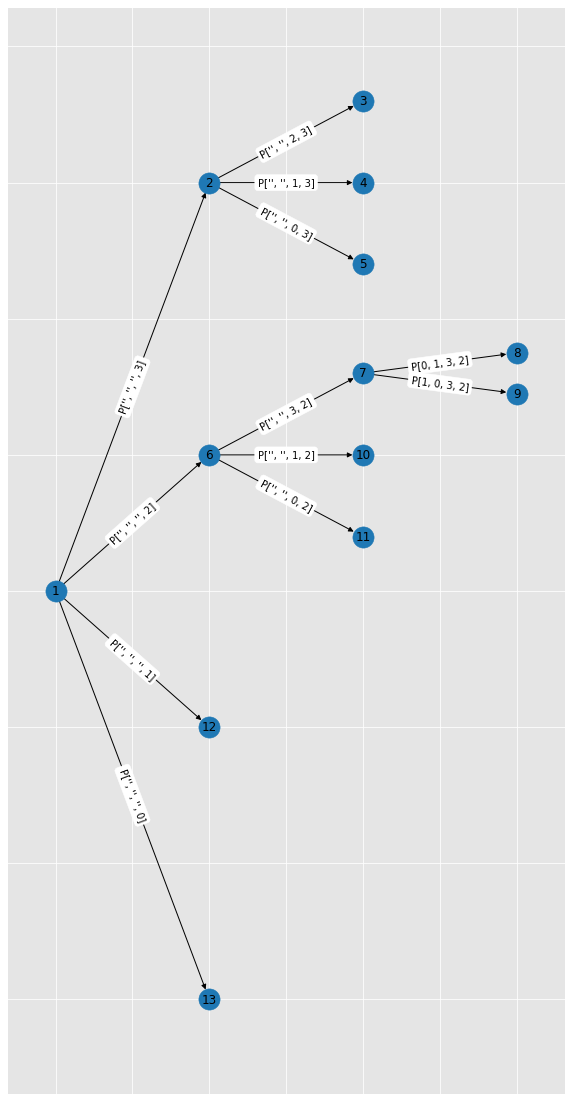


z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.3035702705383301 s
Nombre d'itérations:  14


SOLUTION OBTENUE B&B METHODE 2 (BFS) : 


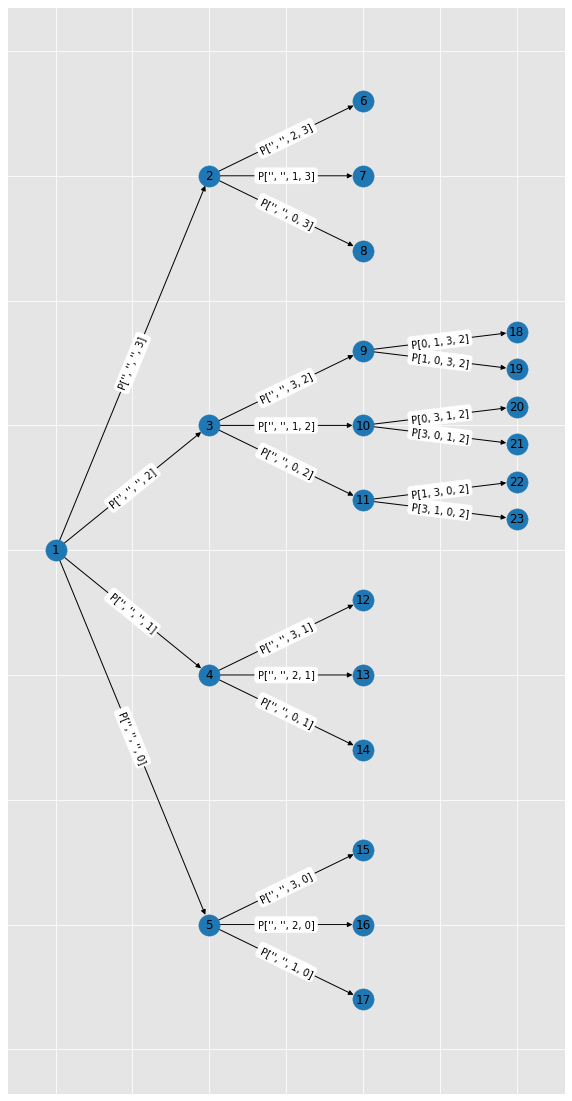


z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.3630397319793701 s
Nombre d'itérations:  24


SOLUTION OBTENUE B&B METHODE 1 (DFS) : 


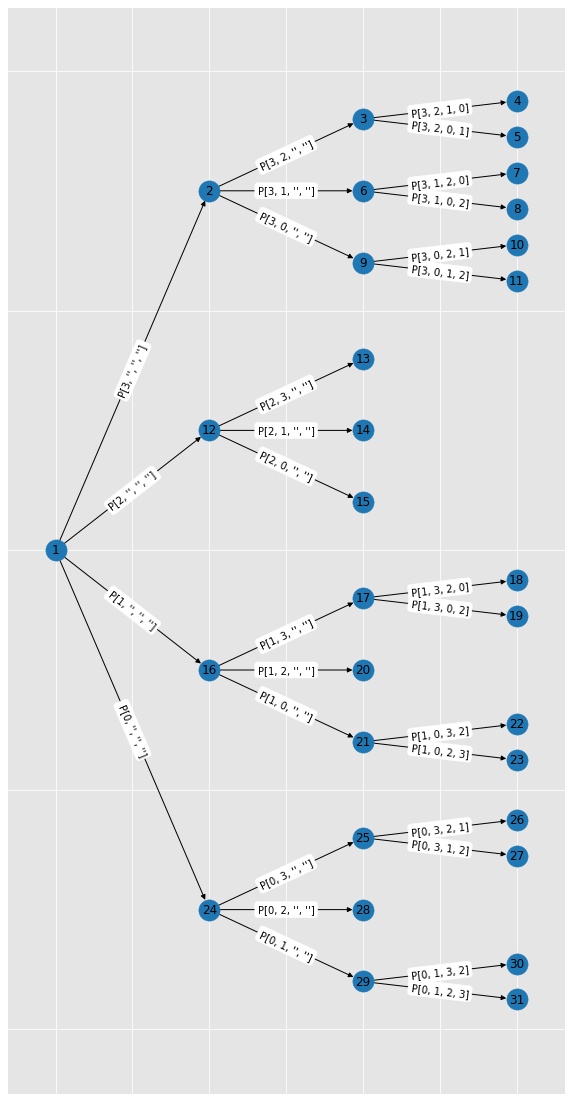


z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.4756135940551758 s
Nombre d'itérations:  32


SOLUTION OBTENUE B&B METHODE 1 (BFS) : 


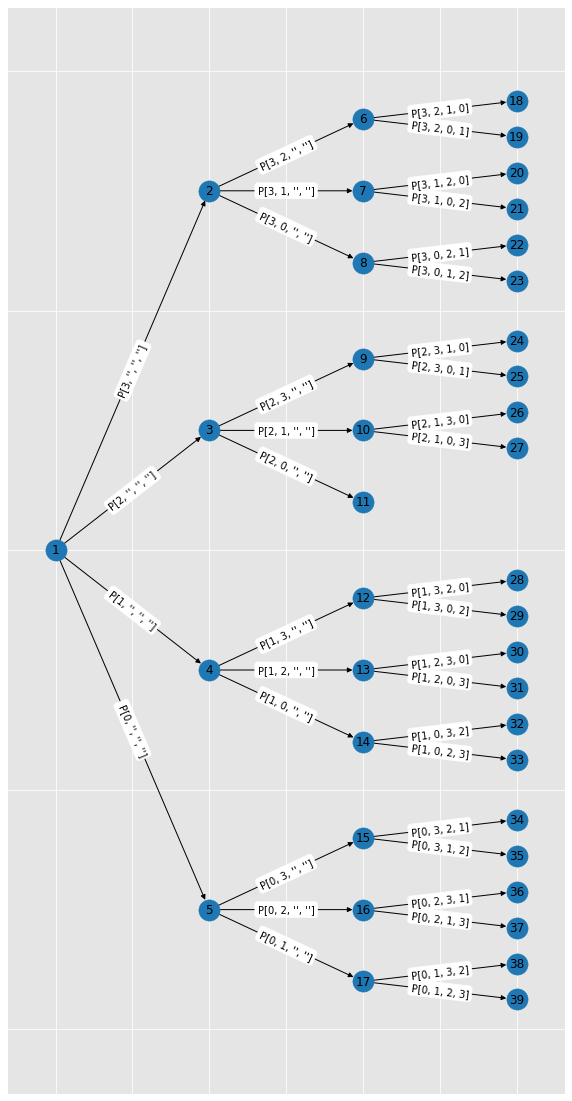


z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.49378252029418945 s
Nombre d'itérations:  40


In [86]:
#Methode 2 avec un parcours en profondeur (DFS):
print("\n\nSOLUTION OBTENUE B&B METHODE 2 (DFS) : ")
t1_bb1 = time.time()
z1,x1,k1 = branch_and_bound(Exemple,primale1,borne_duale2,Branchement2,depth_first_method,affichage=True)
t2_bb1 = time.time()

print("\nz = ",z1,", x = ",x1)
print("Temps exécution B&B: ",t2_bb1-t1_bb1,"s")
print("Nombre d'itérations: ",k1)

#Methode 2 avec un parcours en largeur (BFS):
print("\n\nSOLUTION OBTENUE B&B METHODE 2 (BFS) : ")
t1_bb2 = time.time()
z2,x2,k2 = branch_and_bound(Exemple,primale1,borne_duale2,Branchement2,breadth_first_method,affichage=True)
t2_bb2 = time.time()

print("\nz = ",z2,", x = ",x2)
print("Temps exécution B&B: ",t2_bb2-t1_bb2,"s")
print("Nombre d'itérations: ",k2)

#Methode 1 avec un parcours en profondeur (DFS):
print("\n\nSOLUTION OBTENUE B&B METHODE 1 (DFS) : ")
t1_bb3 = time.time()
z3,x3,k3 = branch_and_bound(Exemple,primale1,borne_duale1,Branchement1,depth_first_method,affichage=True)
t2_bb3 = time.time()

print("\nz = ",z3,", x = ",x3)
print("Temps exécution B&B: ",t2_bb3-t1_bb3,"s")
print("Nombre d'itérations: ",k3)

#Methode 1 avec un parcours en largeur (BFS):
print("\n\nSOLUTION OBTENUE B&B METHODE 1 (BFS) : ")
t1_bb4 = time.time()
z4,x4,k4 = branch_and_bound(Exemple,primale1,borne_duale1,Branchement1,breadth_first_method,affichage=True)
t2_bb4 = time.time()

print("\nz = ",z4,", x = ",x4)
print("Temps exécution B&B: ",t2_bb4-t1_bb4,"s")
print("Nombre d'itérations: ",k4)

La représentation graphique des arbres est très intéressante. En effet, cela nous permet d'expliquer le nombre d'itérations et le temps d'exécution du B&B. Nous pouvons alors confirmer graphiquement des résultats que nous avons déjà remarqué plus tôt.

Par exemple, sur les 4 représentations des arbres d'énumération, nous observons clairement que la méthode 1 visite beaucoup plus de noeuds que la méthode 2 alors que nous sommes seulement sur un problème avec 4 produits. Par conséquent, le nombre d'itérations et le temps d'exécution est de la méthode 1 sont plus élevés.

Nous pouvons aussi observer qu'un parcours en profondeur permet de visiter moins de noeud qu'un parcours en largeur. En effet, le parcours en profondeur permet d'atteindre assez rapidement un noeud fils et de tenter d'obtenir une meilleure borne primale comme nous pouvons le voir sur les différentes représentations.

Cette représentation permet donc de confirmer certains des résultats que nous avons donnés dans la partie **IV-e**. 

Grâce à la visualisation de ces arbres d'énumération, nous pouvons aussi penser qu'il serait intéressant de créer une méthode de calcul de la borne duale donnant des valeurs plus élevées afin d'élaguer plus de noeuds.

Afin de tester un autre exemple, nous allons cette-fois ci comparer 2 bornes primales avec la méthode d'exploration meilleur d'abord.

Pour cela, nous prenons les méthodes **primale_worst** et **primale_best** définies dans les parties précédentes. Nous testons ces 2 bornes primales avec une méthode d'exploration meilleur d'abord et la 2ème règle de branchement sur l'exemple simple que nous avons utilisé dans les parties précédentes avec 4 produits. Voici nos résultats : 



SOLUTION OBTENUE B&B MEILLEURE BORNE PRIMALE : 


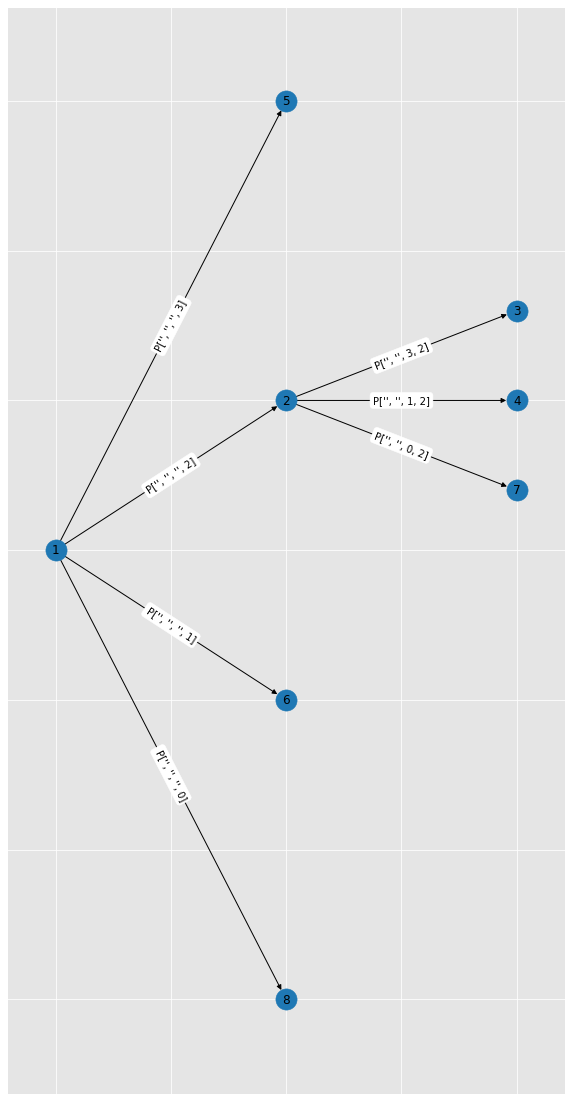


z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.2946021556854248 s
Nombre d'itérations:  9


SOLUTION OBTENUE B&B PIRE BORNE PRIMALE : 


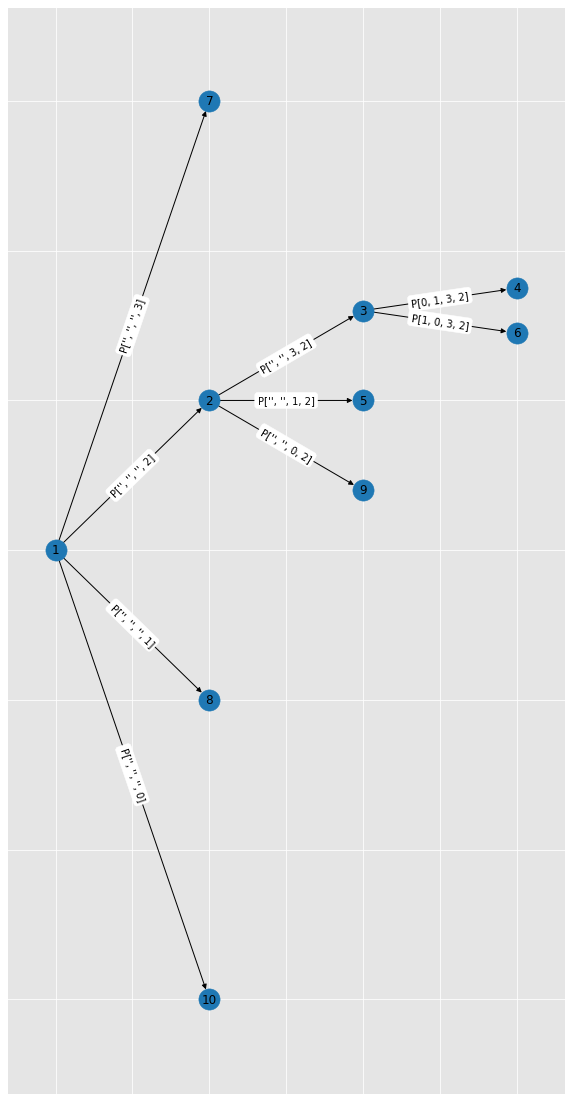


z =  67 , x =  [0, 1, 3, 2]
Temps exécution B&B:  0.26144838333129883 s
Nombre d'itérations:  11


In [87]:
#Methode 2 avec meilleur d'abord et primale_best:
print("\n\nSOLUTION OBTENUE B&B MEILLEURE BORNE PRIMALE : ")
t1_bb1 = time.time()
z1,x1,k1 = branch_and_bound(Exemple,primale_best,borne_duale2,Branchement2,best_first_method,affichage=True)
t2_bb1 = time.time()

print("\nz = ",z1,", x = ",x1)
print("Temps exécution B&B: ",t2_bb1-t1_bb1,"s")
print("Nombre d'itérations: ",k1)

#Methode 2 avec meilleur d'abord et primale_worst:
print("\n\nSOLUTION OBTENUE B&B PIRE BORNE PRIMALE : ")
t1_bb2 = time.time()
z2,x2,k2 = branch_and_bound(Exemple,primale_worst,borne_duale2,Branchement2,best_first_method,affichage=True)
t2_bb2 = time.time()

print("\nz = ",z2,", x = ",x2)
print("Temps exécution B&B: ",t2_bb2-t1_bb2,"s")
print("Nombre d'itérations: ",k2)

Nous pouvons alors observer que pour la meilleure borne primale, nous avons déjà la solution optimale. En effet, si nous regardons son arbre d'énumération, il n'atteint jamais un noeud fils et élague tous les noeuds avant car la borne primale est déjà la meilleure solution.

Pour la pire borne primale, il y a juste 2 itérations de plus. En effet, dès la 4ème itération, l'algorithme de B&B a déjà atteint le noeud fils qui correspond à la solution optimale. L'algorithme a donc créé une branche de plus et visiter 2 noeuds de plus pour obtenir la solution optimale.

Nous observons donc que dans le cas de la méthode d'exploration meilleur d'abord, la borne primale initiale n'est pas si importante. Elle permet de baisser légèrement le nombre d'itérations mais la différence est faible. En effet, la méthode cherche à explorer en priorité les noeuds avec des bonnes bornes duales. Par conséquent, à moins d'avoir une très bonne borne primale, la plupart du temps l'algorithme va vite obtenir un noeud fils avec une bonne solution optimale et donc une bonne borne primale. Nous confirmons donc un résultat que nous avions déjà observé dans la partie **IV-d**.

Nous avons maintenant terminé la partie sur le problème d'ordonnancement simple. Nous allons maintenant vous présenter une extension du problème d'ordonnancement.

## V - Ajout de contraintes de précédence sur les pièces au problème d'ordonnancement 

Nous avons jusqu'ici considéré une version du problème d'ordonnancement dans laquelle les pièces peuvent être usinées dans n'importe qu'elle ordre (on cherche juste le meilleur ordre possible soit celui engendrant le moins de pénalités) mais on peut aussi considérer des contraintes de précédence du type : la pièce $i$ doit être usinée avant la pièce $j$ pour $i,j\in J$ tel que $i\neq j$.

Pour traité, cette configuration, comme nous l'avons dit plus haut, la classe Ordonnancement a été adaptée à cette extension du problème initiale. Elle possède en effet un attribut permettant de stocker des contraintes de précédence sous la forme d'un tableau associatif donnant pour chaque pièce en entrée, une liste de pièces qui doivent être usinées avant celle-ci. Elle dispose également d'une méthode permettant d'ajouter des contraintes de précédence.

Nous avons par ailleurs adapté le programme linéaire en nombre entier permettant de résoudre le problème initiale en lui ajoutant des contraintes permettant d'assurer les contraintes de précédence. On peut remarquer qu'imposer que la pièce $i$ doit passer avant $j$ revient à imposer $x_{i,j} = 1$. On note désormais $\{pred(j)\}_{j\in J}$ l'ensemble constitué d'une liste pour chaque pièce $j\in J$ contenant les pièces qui doivent passer avant la pièce $j$ (Si aucune pièce n'est contrainte de passer avant $j$ alors $\{pred(j)\}_{j\in J} = \emptyset$. Il faut en revanche faire attention à ne pas rendre le problème non-réalisable en ajoutant des contraintes de précédence, par exemple, on ne pas peut imposer que la pièce $i$ doit passer avant la pièce $j$ et en même temps que la pièce $j$ doit passer avant la pièce $i$.

La nouvelle version du PLNE est la suivante:

**Variables:**

 * $\forall j \in J, r_j \ge 0$ est une variable réelle positive représentant le retard en unité de temps de la pièce $j$
 
 * $\forall j \in J, f_j \ge 0$ est une variable réelle positive représentant la date de fin d'usinage de la pièce $j$
 
 * $\forall (i,j)\in J^2$, $x_{i,j} \in \{0,1\}$ est une variable binaire prenant la valeur $1$ si la pièce $i$ passe avant la pièce $j$ et $0$ sinon

**Objectif:**

* On cherche à minimiser les pénalités de retard :

$$ \min{\sum_{j\in J}{\omega_j r_j}}$$

**Contraintes:**

* On impose la contrainte suivante pour calculer le retard de chaque pièce :
$$ r_j \ge f_j - d_j,\quad \forall j \in J$$

* On impose la contrainte suivatne pour calculer la date de fin d'usinage de chaque pièce :
$$ f_j = T_j + \sum_{i \in J \\ i\neq j}{T_i x_{ij}} \quad \forall j \in J$$

* On impose une relation d'ordre total sur le passage des pièces :
$$ x_{ij} + x_{ji} = 1 \quad \forall (i,j) \in J^2, \: i < j$$
$$ x_{ik} \ge x_{ij} + x_{jk}-1\quad \forall (i,j,k) \in J^3, \: i<j, \: i<k, j\neq k$$

* On impose enfin les contraintes de précédence entre les pièces :
$$ x_{ij} = 1 \quad \forall j \in J, \: \forall i \in pred(j) $$

On peut noter que "nouvelle" version du PLNE reste très générique puisqu'elle coïncide directement avec la version précédence lorsqu'il n'y a pas de contraintes de précédence, c'est-à-dire lorsque $\forall j \in J, \: pred(j) =\emptyset$ (dans ce cas on impose à aucune variable $x_{ij}$ d'être égale à 1 et on retombe bien sur le problème d'ordonnancement simple). C'est d'ailleurs directement cette version générique du PLNE que nous avons implémenté dans la classe ordonnancement. 

Essayer d'appliquer quelques contraintes de précédence sur l'exemple basique donné en introduction :

In [88]:
Exemple_precedence = Ordonnancement()
P = [4,5,3,5] #Pénalités
T = [12,8,15,9] #Unités de temps nécessaires
D = [16,26,25,27] #Deadlines
Exemple_precedence.ajouterPieces(T,D,P)
Exemple_precedence.afficherProbleme()
Exemple_precedence.resolutionPLNE()


AFFICHAGE DU PROBLEME:

############### PIECES ##############
Piece n° 0 : [Unités de temps nécessaires:  12 , Deadline:  16 , Pénalité par unité de temps de retard:  4 ]
Piece n° 1 : [Unités de temps nécessaires:  8 , Deadline:  26 , Pénalité par unité de temps de retard:  5 ]
Piece n° 2 : [Unités de temps nécessaires:  15 , Deadline:  25 , Pénalité par unité de temps de retard:  3 ]
Piece n° 3 : [Unités de temps nécessaires:  9 , Deadline:  27 , Pénalité par unité de temps de retard:  5 ]
###### CONTRAINTES PRECEDENCES ######
Pas de contraintes de précédence

SOLUTION OBTENUE PLNE:

Solve with CBC, Status: Optimal
Total des pénalités: 67.0
Ordre d'usinage des pièces: [0, 1, 3, 2]


Lorsque l'on ajoute aucune contrainte de précédence, on retombe simplement sur le problème d'ordonnancement précédent dont la valeur optimale est de $67$. Essayons maintenant d'ajouter une contrainte imposant que les pièces 0, 2 et 3 doivent passer avant la pièce 1.

In [89]:
Exemple_precedence.ajouterContraintePrecedence(1,[0,2,3])
Exemple_precedence.afficherProbleme()
Exemple_precedence.resolutionPLNE()


AFFICHAGE DU PROBLEME:

############### PIECES ##############
Piece n° 0 : [Unités de temps nécessaires:  12 , Deadline:  16 , Pénalité par unité de temps de retard:  4 ]
Piece n° 1 : [Unités de temps nécessaires:  8 , Deadline:  26 , Pénalité par unité de temps de retard:  5 ]
Piece n° 2 : [Unités de temps nécessaires:  15 , Deadline:  25 , Pénalité par unité de temps de retard:  3 ]
Piece n° 3 : [Unités de temps nécessaires:  9 , Deadline:  27 , Pénalité par unité de temps de retard:  5 ]
###### CONTRAINTES PRECEDENCES ######
La pièce 0 doit passer avant la pièce 1
La pièce 2 doit passer avant la pièce 1
La pièce 3 doit passer avant la pièce 1

SOLUTION OBTENUE PLNE:

Solve with CBC, Status: Optimal
Total des pénalités: 123.0
Ordre d'usinage des pièces: [0, 3, 2, 1]


On note que la valeur optimale et la solution au problème ont changé et la valeur optimale du nouveau problème est en particulier plus grande que celle du problème initiale (Il s'agit en fait d'une restriction du problème précédent). On remarque bien sûr que la solution obtenue respecte bien les contraites de précédence imposées. Essayons maintenant d'imposer les 2 contraintes suivantes : la pièce 1 doit passer avant la pièce 0 et la pièce 0 doit passer avant la pièce 1.

In [90]:
Exemple_precedence.ajouterContraintePrecedence(1,[0])
Exemple_precedence.ajouterContraintePrecedence(0,[1])
Exemple_precedence.afficherProbleme()
Exemple_precedence.resolutionPLNE()


AFFICHAGE DU PROBLEME:

############### PIECES ##############
Piece n° 0 : [Unités de temps nécessaires:  12 , Deadline:  16 , Pénalité par unité de temps de retard:  4 ]
Piece n° 1 : [Unités de temps nécessaires:  8 , Deadline:  26 , Pénalité par unité de temps de retard:  5 ]
Piece n° 2 : [Unités de temps nécessaires:  15 , Deadline:  25 , Pénalité par unité de temps de retard:  3 ]
Piece n° 3 : [Unités de temps nécessaires:  9 , Deadline:  27 , Pénalité par unité de temps de retard:  5 ]
###### CONTRAINTES PRECEDENCES ######
La pièce 0 doit passer avant la pièce 1
La pièce 2 doit passer avant la pièce 1
La pièce 3 doit passer avant la pièce 1
La pièce 0 doit passer avant la pièce 1
La pièce 1 doit passer avant la pièce 0

SOLUTION OBTENUE PLNE:

Solve with CBC, Status: Infeasible
Erreur lors de la résolution


On obtient ainsi comme c'était attendu une instance non-réalisable du probleme d'ordonnancement. 

Regardons maintenant ce qu'il en est dans l'arbre d'énumération de l'algorithme de Branch-and-Bound lorsque l'on prend en compte ces nouvelles contraintes. D'abord, avec la méthode de branchement 1, on peut remarquer que certains noeuds de l'arbre correspondent à des problèmes non-réalisables. De plus, tous les noeuds fils qui descendent de ces noeuds en questions seront également non-réalisables. Considérons une instance composée de 3 pièces $0$, $1$ et $2$ et on impose que la pièce $2$ doit passer avant la pièce $1$. On observe par exemple au niveau $k=2$ que le noeud $P_{1,\,2, \,.}$ ne respecte pas la contrainte de précédence et que son unique noeud fils $P_{1,\,2,\,0}$ ne l'a respecte pas non plus. On peut donc directement élaguer ce noeud et son descendant (De même, les noeuds solution $P_{0,\,1,\,2}$ et $P_{1,\,0,\,2}$ ne respectent pas non plus cette contraintes). 

![image.png](img/GrapheDebutPrecedence.PNG)

Ainsi, avec la méthode 1, on peut en parcourant l'arbre d'énumération élaguer des noeuds et leurs descendants si ils ne respectent pas les contraintes de précédence. Dans la règle de branchement, supposons que l'on veuille créer un nouveau noeud $N$ en ajoutant la pièce $j$ au noeud père qui contient un ensemble de pièces $J'$. On peut vérifier que celui-ci respecte ou non les contraintes de précédence en regardant si toutes les pièces $i$ devant passer avant $j$ se trouvent dans la liste de pièces $J'$ du noeud père car si ce n'est pas le cas, cela signifie qu'elles seront ajoutées plus tard dans les noeuds descendants de $N$ et qu'elles se retrouveront donc après la pièce $j$ (non-respect de la contrainte de précédence !).

Si on reprend l'arbre ci-dessus, cela signifie que dès le niveau $k=1$, on pouvait prévoir que le noeud $P_{1,\,.,\,.}$ n'allait pas pouvoir engendrer de solutions réalisables puisqu'on lui a ajouté la pièce 1 sans qu'il ne contienne la pièce 2 (on rappelle que la pièce 2 doit apparaître avant la pièce 1).

![image.png](img/GrapheDebutPrecedence2.PNG)

On implémente donc cette procédure dans la fonction Branchement1_pred. Comme pour les méthodes de branchement précédentes, celle-ci prend en paramètre l'**arbre** d'énumération, **l'instance** du problème et **indice_pere** qui correspond à l'indice du noeud père dans la liste des noeuds et elle retourne la liste des noeuds crées (**new_node**).

In [91]:
def Branchement1_pred(arbre,instance,indice_pere):
    #recuperation du noeud que nous traitons
    noeud=arbre.noeuds[indice_pere]
    #initialisation de la liste qui va contenir les noeuds que nous allons creer
    new_node=[]
    #recuperation des pieces non usinees
    pieces_non_usinees = [i for i in range(instance.nb_piece) if i not in noeud.info]
    #si il reste que deux pieces non usinees alors c'est un noeud fils
    if(len(pieces_non_usinees) == 2):
        position = True
    else:
        position = False
    #creation des nouveaux noeuds
    for i in pieces_non_usinees:
        #Avant de créer un nouveau noeud, on verifie qu'il respecte les contraintes de precedence
        if(i in instance.contraintesPrecedence):
            if(not all(piece in noeud.info for piece in instance.contraintesPrecedence[i])):
                continue
        new_info = noeud.info.copy()
        new_info.append(i)
        des = "P"
        for piece in noeud.info:
            des += str(piece)
        des += str(i)
        new_node.append(Noeud(des,position,new_info,indice_pere))
    #nous retournons la liste des nouveaux noeuds
    return new_node

De la même manière, avec la méthode 2, on peut remarquer que certains noeuds ne sont pas réalisables. Reprenons l'exemple contenant 3 pièces : $0$, $1$ et $2$ avec la contrainte que $2$ doit passer avant la pièce $1$. L'arbre d'énumération associé à la méthode 2 est représenté ci-dessous. Sur ce dernier, on remarque qu'au niveau $k=2$ que le noeud $P_{.,\,1, \,2}$ et son unique noeud fils ne respecte pas la contrainte de précédence (idem pour les noeuds solutions $P_{1,\,0, \,2}$ et $P_{1,\,2, \,0}$). De manière analogue à la méhtode 1, on peut aussi élaguer des noeuds dans l'arbre ainsi que leurs descendants.

![image.png](img/GrapheFinPrecedence.PNG)

Dans la règle de branchement associée à la méthode 2, supposons que l'on veut créer un nouveau noeud $N$ en ajoutant en dernière position disponible la pièce $j$ au noeud père qui contient un ensemble de pièces $J'$ (cette fois-ci en partant de la fin). On peut vérifier que celui-ci respecte ou non les contraintes de précédence en regardant si toutes les pièces $i$ devant passer avant $j$ ne se trouvent pas dans la liste de pièces $J'$ du noeud père car si ce n'est pas le cas, cela signifie qu'elles seront usinées après $j$ (non-respect de la contrainte de précédence !).

De la même manière, on peut coder cette nouvelle procédure dans fonction Branchement2_pred qui, sur le même modèle que les autres fonctions Branchement prend en paramètre l'**arbre** d'énumération, **l'instance** du problème et **indice_pere** qui correspond à l'indice du noeud père dans la liste des noeuds. Cette fonction retourne également la liste des noeuds crées (**new_node**).

In [92]:
def Branchement2_pred(arbre,instance,indice_pere):
    #recuperation du noeud que nous traitons
    noeud=arbre.noeuds[indice_pere]
    #initialisation de la liste qui va contenir les noeuds que nous allons creer
    new_node=[]
    #recuperation des pieces non usinees
    pieces_non_usinees = [i for i in range(instance.nb_piece) if i not in noeud.info]
    #si il reste que deux pieces non usinees alors c'est un noeud fils
    if(len(pieces_non_usinees) == 2):
        position = True
    else:
        position = False
    #creation des nouveaux noeuds
    for i in pieces_non_usinees:
        #Avant de creer un nouveau noeud on s'assure qu'il respecte bien les contraintes de precedence
        if(i in instance.contraintesPrecedence):
            if(any(piece in noeud.info for piece in instance.contraintesPrecedence[i])):
                continue
        new_info = noeud.info.copy()
        new_info.insert(0,i)
        #Si il s'agit d'un noeud fils, on s'assure qu'il reste toujours réalisable en ajoutant les dernières pieces
        if(position):
            derniere_piece = [x for x in range(instance.nb_piece) if x not in new_info]
            if(derniere_piece[0] in instance.contraintesPrecedence):
                if(any(piece in noeud.info for piece in instance.contraintesPrecedence[derniere_piece[0]])):
                    continue
        des = "P"
        for piece in pieces_non_usinees:
            des += "."
        for piece in noeud.info:
            des += str(piece)
        des += str(i)
        new_node.append(Noeud(des,position,new_info,indice_pere))
    #nous retournons la liste des nouveaux noeuds
    return new_node

Notons que pour traiter cette extension du problème d'ordonnancement, nous n'avons eu besoin que d'adapter nos méthodes de branchement. Le reste des fonctionnalités de l'algorithme de Branch-and-bound reste globalement inchangé, en particulier les méthodes d'exploration des noeuds et les méthodes de calcul des bornes duales. Cependant, certaines méthode permettant de calculer des bornes primales initiales ne sont ici plus valides car les solutions qu'elles renvoient ne respectent pas forcément les contraintes de précédence. Notons également que ces nouvelles implémentation des méthodes de branchement sont génériques et qu'elles s'adaptent parfaitement au cas où il n'y a pas de contraintes d'ordonnancement dans le problème (on retombe ainsi sur le problème d'ordonnancement initial).

Pour obtenir une borne primale initiale, on peut chercher à calculer une borne supérieure à toutes les solutions possibles du problème d'ordonnancement (avec ou sans contraintes de précédence). On peut remarquer que pour une instance donnée, pour toute pièce $j\in J$, que le plus grand retard possible que pourra engendré cette pièce correspond au cas où elle passera en dernière position, c'est-à-dire:
$$\forall j\in J, \quad r_j \le \max{(0,\sum_{i\in J}{T_i - d_j})}$$
On en déduit ainsi une borne supérieure sur la valeur de la fonction obectif:
$$\sum_{j\in J}{\omega_j r_j} \le \sum_{j\in J}{\omega_j \max{(0,\sum_{i\in J}{T_i - d_j})}}$$
La fonction primale4 permet de calculer une borne primale initiale pour une instance du problème donné (avec ou sans contrainte de précédence) à partir de cette méthode. Elle prend en paramètre une **instance** du problème et retourne en sortie la valeur de la borne primale initiale ainsi qu'une solution vide (Cette solution sera forcément mise-à-jour plus tard lors de l'exécution de l'algorithme de Branch-and-bound puisque cette borne primale initiale est supérieure aux valeurs objectives de toutes les solutions réalisables). 

In [93]:
def primale4(instance):
    borne = 0
    date_fin = sum(instance.unite_temps)
    for i in range(instance.nb_piece):
        borne += max(0,date_fin - instance.deadlines[i])*instance.penalites[i]
    return(borne,[])

Nous allons maintenant réaliser quelques tests pour une instance aléatoire du problème contenant 8 pièces ($J = \{0,...,7\}$). Pour générer aléatoirement des contraintes de précédence, on utilisera la méthode suivante par la suite : parmi toutes les pièces de $J$, on choisit aléatoirement une pièce $i$ et on scinde l'ensemble des pièces restantes $J\backslash \{i\}$ en 2 groupes de taille aléatoire $J_1$ et $J_2$ tels que $J_1 \cap J_2 = \emptyset$ et $J = J_1 \cup J_2 \cup \{i\} $. On impose ensuite que toutes les pièces de $J_1$ passe avant $i$ et que toutes les pièces de $J_2$ passent après $i$. L'instance du problème crée sera d'abord résolue avec le modèle PLNE afin de vérifier la validité du résultat puis nous testerons chacune des 2 méthodes de branchement pour notre algorithme de Branch-and-bound (on testera aussi plusieurs méthodes de parcours de l'arbre d'énumération).

In [94]:
#Taille du problème (nombre de pieces)
n = 8
#Creation de l'instance aleatoire de taille n
probleme = Ordonnancement()
probleme.problemeAleatoire(n)

#Contraintes de precedence:
pieces = list(range(n)) #liste des pieces
p = random.choice(pieces) #on récupere une piece aleatoirement
pieces.remove(p) #on retire cette piece de la liste
random.shuffle(pieces) #on melange les pieces restantes
cut = random.randint(0, len(pieces))
#partition de l'ensemble des pieces restantes
before = pieces[:cut] 
after = pieces[cut:] 
#Les pieces de before doivent passer avant p
probleme.ajouterContraintePrecedence(p,before)
#Les pieces de after doivent passer apres p
for j in after:
    probleme.ajouterContraintePrecedence(j,[p])
probleme.afficherProbleme()


#Resolution PLNE:
t1_plne = time.time()
probleme.resolutionPLNE()
t2_plne = time.time()
print("Temps exécution pulp: ",t2_plne-t1_plne,"s")


#Methode 1 avec parcours en profondeur (BFS)
t1_bb1 = time.time()
z1,x1,k1 = branch_and_bound(probleme,primale4,borne_duale1,Branchement1_pred,depth_first_method)
t2_bb1 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 1 (DFS) : \n\nz = ",z1,", x = ",x1)
print("Temps exécution B&B: ",t2_bb1-t1_bb1,"s")
print("Nombre d'itérations: ",k1)


#Methode 1 avec un parcours en largeur (BFS):
t1_bb2 = time.time()
z2,x2,k2 = branch_and_bound(probleme,primale4,borne_duale1,Branchement1_pred,breadth_first_method)
t2_bb2 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 1 (BFS) : \n\nz = ",z2,", x = ",x2)
print("Temps exécution B&B: ",t2_bb2-t1_bb2,"s")
print("Nombre d'itérations: ",k2)


#Methode 1 avec 'meilleur d'abord':
t1_bb3 = time.time()
z3,x3,k3 = branch_and_bound(probleme,primale4,borne_duale1,Branchement1_pred,best_first_method)
t2_bb3 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 1 (Meilleur d'abord) : \n\nz = ",z3,", x = ",x3)
print("Temps exécution B&B: ",t2_bb3-t1_bb3,"s")
print("Nombre d'itérations: ",k3)


#Methode 1 avec la méthode mixte:
t1_bb4 = time.time()
z4,x4,k4 = branch_and_bound(probleme,primale4,borne_duale1,Branchement1_pred,mixed_method)
t2_bb4 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 1 (Mixte) : \n\nz = ",z4,", x = ",x4)
print("Temps exécution B&B: ",t2_bb4-t1_bb4,"s")
print("Nombre d'itérations: ",k4)


#Methode 2 avec un parcours en profondeur (DFS):
t1_bb5 = time.time()
z5,x5,k5 = branch_and_bound(probleme,primale4,borne_duale2,Branchement2_pred,depth_first_method)
t2_bb5 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 2 (DFS) : \n\nz = ",z5,", x = ",x5)
print("Temps exécution B&B: ",t2_bb5-t1_bb5,"s")
print("Nombre d'itérations: ",k5)


#Methode 2 avec un parcours en largeur (BFS):
t1_bb6 = time.time()
z6,x6,k6 = branch_and_bound(probleme,primale4,borne_duale2,Branchement2_pred,breadth_first_method)
t2_bb6 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 2 (BFS) : \n\nz = ",z6,", x = ",x6)
print("Temps exécution B&B: ",t2_bb6-t1_bb6,"s")
print("Nombre d'itérations: ",k6)


#Methode 2 avec 'meilleur d'abord':
t1_bb7 = time.time()
z7,x7,k7 = branch_and_bound(probleme,primale4,borne_duale2,Branchement2_pred,best_first_method)
t2_bb7 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 2 (Meilleur d'abord) : \n\nz = ",z7,", x = ",x7)
print("Temps exécution B&B: ",t2_bb7-t1_bb7,"s")
print("Nombre d'itérations: ",k7)

#Methode 2 avec la méthode mixte:
t1_bb8 = time.time()
z8,x8,k8 = branch_and_bound(probleme,primale4,borne_duale2,Branchement2_pred,mixed_method)
t2_bb8 = time.time()

print("\n\nSOLUTION OBTENUE B&B METHODE 2 (Mixte) : \n\nz = ",z8,", x = ",x8)
print("Temps exécution B&B: ",t2_bb8-t1_bb8,"s")
print("Nombre d'itérations: ",k8)


AFFICHAGE DU PROBLEME:

############### PIECES ##############
Piece n° 0 : [Unités de temps nécessaires:  1 , Deadline:  35 , Pénalité par unité de temps de retard:  2 ]
Piece n° 1 : [Unités de temps nécessaires:  8 , Deadline:  33 , Pénalité par unité de temps de retard:  1 ]
Piece n° 2 : [Unités de temps nécessaires:  3 , Deadline:  30 , Pénalité par unité de temps de retard:  1 ]
Piece n° 3 : [Unités de temps nécessaires:  9 , Deadline:  39 , Pénalité par unité de temps de retard:  10 ]
Piece n° 4 : [Unités de temps nécessaires:  20 , Deadline:  28 , Pénalité par unité de temps de retard:  1 ]
Piece n° 5 : [Unités de temps nécessaires:  15 , Deadline:  36 , Pénalité par unité de temps de retard:  3 ]
Piece n° 6 : [Unités de temps nécessaires:  18 , Deadline:  37 , Pénalité par unité de temps de retard:  3 ]
Piece n° 7 : [Unités de temps nécessaires:  10 , Deadline:  24 , Pénalité par unité de temps de retard:  8 ]
###### CONTRAINTES PRECEDENCES ######
La pièce 7 doit passer avant l

On remarque que sur tous les tests réalisés ci-dessus, on trouve la même valeur objectif que le PLNE. De plus, on remarque que dans les solutions proposées, les contraintes de précédence sont respectées comme c'était attendu. Ceci confirme donc le bon fonctionnement de nos nouvelles méthodes de branchement adaptées à la restriction du problème d'ordonnancement implémentant des contraintes de précédence. On peut déjà remarquer que la méthode 1 semble être plus efficace que la méthode 2 pour traiter ce genre de problème.

Essayons maintenant de regarder le comportement de notre algorithme lorsque l'on augmente la taille de l'instance à traiter. Pour une taille $n$ croissante, nous allons créer des instances du problème d'ordonnancement et ajouter des contraintes de précédence sur le même modèle que ce qui a été décrit précédemment. A chaque itération, nous allons résoudre le problème donné en utilisant la méthode 1 et la méthode combinée avec les 4 méthodes d'exploration (DFS, BFS, "Meilleur d'abord" et mixte). La borne primale initiale sera systématiquement calculée avec la fonction primale4. Nous mesurerons le temps d'éxecution de l'algorithme ainsi que son nombre d'itérations pour converger dans chacune des configurations étudiées.

Traitement instance de taille =  1
Traitement instance de taille =  2
Traitement instance de taille =  3
Traitement instance de taille =  4
Traitement instance de taille =  5
Traitement instance de taille =  6
Traitement instance de taille =  7
Traitement instance de taille =  8
Traitement instance de taille =  9


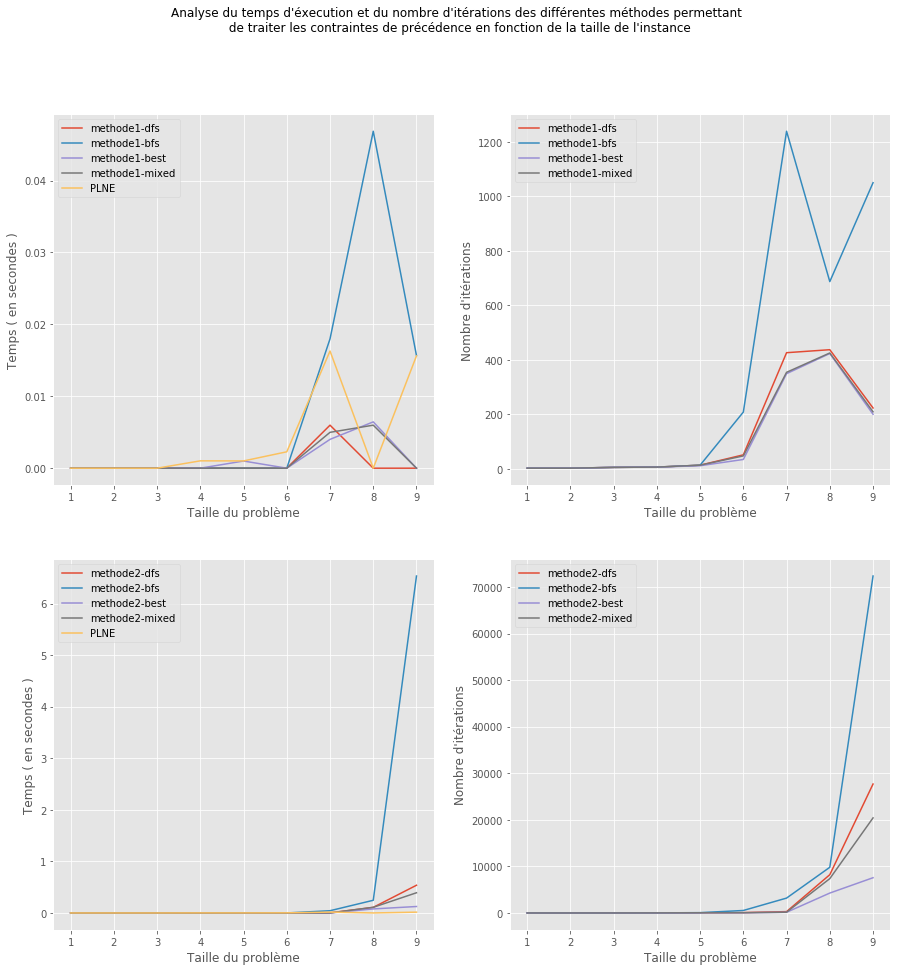

In [95]:
#differentes tailles d'instance pour les tests
val=[i for i in range(1,10)]

#liste pour sauvegarder tps d'execution et nb iterations

t_plne=[] #tps d'execution et nb iterations pour le PLNE

t_m1_dfs=[] #tps d'execution et nb iterations pour methode 1 + DFS
t_m1_bfs=[] #tps d'execution et nb iterations pour methode 1 + BFS
t_m1_best=[] #tps d'execution et nb iterations pour methode 1 + "Meilleur d'abord"
t_m1_mixed=[] #tps d'execution et nb iterations pour methode 1 + "Meilleur d'abord"

t_m2_dfs=[] #tps d'execution et nb iterations pour methode 2 + DFS
t_m2_bfs=[] #tps d'execution et nb iterations pour methode 2 + BFS
t_m2_best=[]#tps d'execution et nb iterations pour methode 2 + "Meilleur d'abord"
t_m2_mixed=[] #tps d'execution et nb iterations pour methode 2 + "Meilleur d'abord"

for n in val:
    print("Traitement instance de taille = ",n)
    #Creation du probleme:
    probleme = Ordonnancement()
    probleme.problemeAleatoire(n)
    #Ajout des contraintes de precedence:
    pieces = list(range(n))
    p = random.choice(pieces)
    pieces.remove(p)
    random.shuffle(pieces) 
    cut = random.randint(0, len(pieces))
    before = pieces[:cut] 
    after = pieces[cut:] 
    probleme.ajouterContraintePrecedence(p,before)
    for j in after:
        probleme.ajouterContraintePrecedence(j,[p])

    #Resolution PLNE
    t1_plne = time.time()
    probleme.resolutionPLNE(afficheTout=0)
    t_plne.append(time.time()-t1_plne)

    #Methode 1 avec un parcours en profondeur (DFS):
    t1_bb1 = time.time()
    z1,x1,k1 = branch_and_bound(probleme,primale4,borne_duale1,Branchement1_pred,depth_first_method)
    t_m1_dfs.append([time.time()-t1_bb1,k1])


    #Methode 1 avec un parcours en largeur (BFS):
    t1_bb2 = time.time()
    z2,x2,k2 = branch_and_bound(probleme,primale4,borne_duale1,Branchement1_pred,breadth_first_method)
    t_m1_bfs.append([time.time()-t1_bb2,k2])


    #Methode 1 avec un parcours "meilleur d'abord":
    t1_bb3 = time.time()
    z3,x3,k3 = branch_and_bound(probleme,primale4,borne_duale1,Branchement1_pred,best_first_method)
    t_m1_best.append([time.time()-t1_bb3,k3])

    #Methode 1 avec un parcours méthode mixte:
    t1_bb4 = time.time()
    z4,x4,k4 = branch_and_bound(probleme,primale4,borne_duale1,Branchement1_pred,mixed_method)
    t_m1_mixed.append([time.time()-t1_bb4,k4])

    #Methode 2 avec un parcours en profondeur (DFS):
    t1_bb1 = time.time()
    z1,x1,k1 = branch_and_bound(probleme,primale4,borne_duale2,Branchement2_pred,depth_first_method)
    t_m2_dfs.append([time.time()-t1_bb1,k1])

    #Methode 2 avec un parcours en largeur (BFS):
    t1_bb2 = time.time()
    z2,x2,k2 = branch_and_bound(probleme,primale4,borne_duale2,Branchement2_pred,breadth_first_method)
    t_m2_bfs.append([time.time()-t1_bb2,k2])

    #Methode 2 avec un parcours "meilleur d'abord":
    t1_bb3 = time.time()
    z3,x3,k3 = branch_and_bound(probleme,primale4,borne_duale2,Branchement2_pred,best_first_method)
    t_m2_best.append([time.time()-t1_bb3,k3])

    #Methode 2 avec un parcours méthode mixte:
    t1_bb4 = time.time()
    z4,x4,k4 = branch_and_bound(probleme,primale4,borne_duale2,Branchement2_pred,mixed_method)
    t_m2_mixed.append([time.time()-t1_bb4,k4])
        
#Affichage resultats
plt.figure(figsize=(15,15))
plt.suptitle("Analyse du temps d'éxecution et du nombre d'itérations des différentes méthodes permettant \n de traiter les contraintes de précédence en fonction de la taille de l'instance")

label=["methode1-dfs","methode1-bfs","methode1-best","methode1-mixed"]
plt.subplot(221)
for t,l in zip([t_m1_dfs,t_m1_bfs,t_m1_best,t_m1_mixed],label):
    plt.plot(val,[z[0] for z in t],label=l)
plt.ylabel("Temps ( en secondes )")
plt.xlabel("Taille du problème")
plt.plot(val,t_plne,label="PLNE")
plt.legend()
    
plt.subplot(222)
for (t,l) in zip([t_m1_dfs,t_m1_bfs,t_m1_best,t_m1_mixed],label):
    plt.plot(val,[z[1] for z in t],label=l)
plt.ylabel("Nombre d'itérations")
plt.xlabel("Taille du problème")
plt.legend()

label=["methode2-dfs","methode2-bfs","methode2-best","methode2-mixed"]
plt.subplot(223)
for t,l in zip([t_m2_dfs,t_m2_bfs,t_m2_best,t_m2_mixed],label):
    plt.plot(val,[z[0] for z in t],label=l)
plt.ylabel("Temps ( en secondes )")
plt.xlabel("Taille du problème")
plt.plot(val,t_plne,label="PLNE")
plt.legend()
    
plt.subplot(224)
for (t,l) in zip([t_m2_dfs,t_m2_bfs,t_m2_best,t_m2_mixed],label):
    plt.plot(val,[z[1] for z in t],label=l)
plt.ylabel("Nombre d'itérations")
plt.xlabel("Taille du problème")
plt.legend()

plt.show()

Sur les graphiques donnés en sortie, on remarque que globalement le nombre d'itérations et le temps d'éxecution augmentent lorsque la taille du problème augmente quelques soient les méthodes utilisées dans l'algorithme de Branch-and-Bound. On remarque également que quelques soient les méthodes utilisées, la méthode d'exploration BFS est complètement dépassée par les autres. Essayons maintenant de refaire ces analyses uniquement pour les 3 autres méthodes d'explorations (DFS, meilleure d'abord et mixte). Cette fois,pour chaque taille d'instance, on estimera les temps d'exécution et les nombres d'itérations en faisant une moyenne sur 10 instances générées aléatoirement (pour une taille donnée).

taille instance =  1
taille instance =  2
taille instance =  3
taille instance =  4
taille instance =  5
taille instance =  6
taille instance =  7
taille instance =  8
taille instance =  9


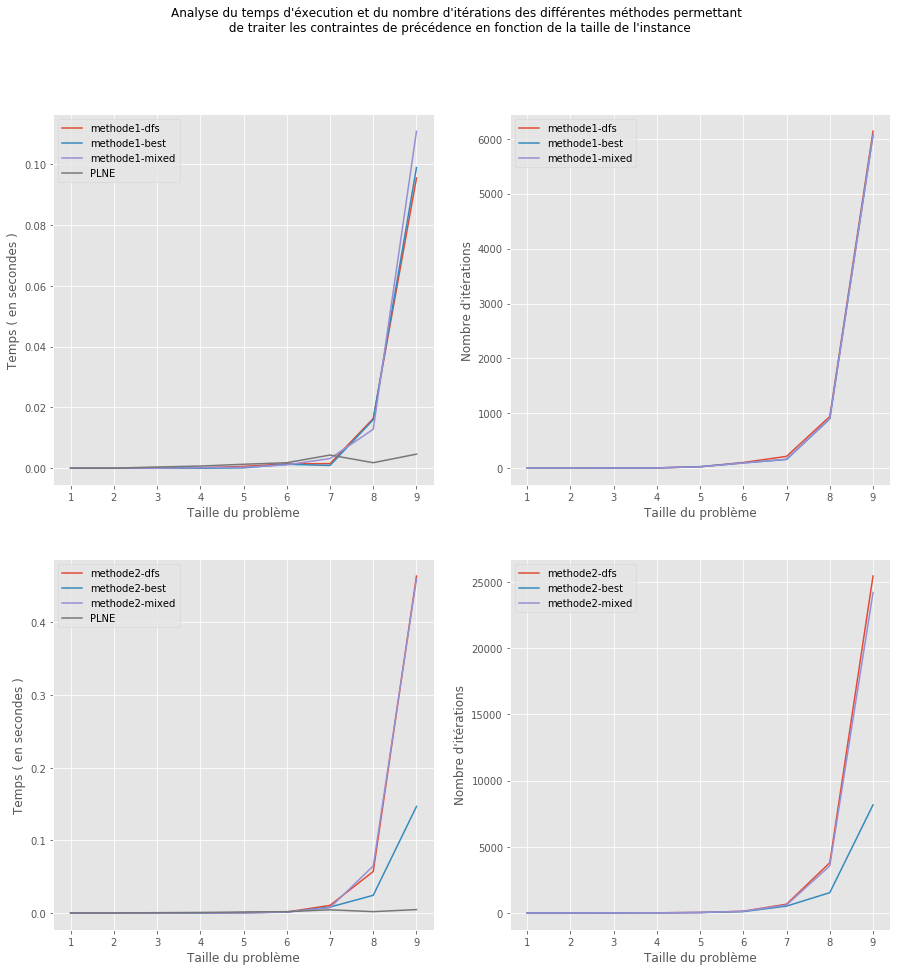

In [96]:
#differentes tailles d'instance pour les tests
val=[i for i in range(1,10)]

#liste pour sauvegarder tps d'execution et nb iterations
t_plne_mean=[] #tps moyen d'execution et nb moyen d'iterations pour le PLNE

t_m1_dfs_mean=[] #tps moyen d'execution et nb moyen d'iterations pour Methode 1 + BFS
t_m1_best_mean=[] #tps moyen d'execution et nb moyen d'iterations pour Methode 1 + "Meilleur d'abord"
t_m1_mixed_mean=[] #tps moyen d'execution et nb moyen d'iterations pour Methode 1 + Mixte

t_m2_dfs_mean=[] #tps moyen d'execution et nb moyen d'iterations pour Methode 2 + BFS
t_m2_best_mean=[] #tps moyen d'execution et nb moyen d'iterations pour Methode 2 + "Meilleur d'abord"
t_m2_mixed_mean=[] #tps moyen d'execution et nb moyen d'iterations pour Methode 2 + Mixte

#Taille des échantillons pour calculer la moyenne
M = 10

for n in val:
    print("taille instance = ",n)
    #Creation des liste pour calculer la moyenne 
    t_plne=[] 
    t_m1_dfs=[] ; t_m1_bfs=[] ; t_m1_best=[] ; t_m1_mixed=[]
    t_m2_dfs=[] ; t_m2_bfs=[] ; t_m2_best=[] ; t_m2_mixed=[]
    for l in range(M):
        #Creation du probleme 
        probleme = Ordonnancement()
        probleme.problemeAleatoire(n)
        #Contraintes de precedence
        pieces = list(range(n))
        p = random.choice(pieces)
        pieces.remove(p)
        random.shuffle(pieces) 
        cut = random.randint(0, len(pieces))
        before = pieces[:cut] 
        after = pieces[cut:] 
        probleme.ajouterContraintePrecedence(p,before)
        for j in after:
            probleme.ajouterContraintePrecedence(j,[p])

        #Resolution PLNE
        t1_plne = time.time()
        probleme.resolutionPLNE(afficheTout=0)
        t_plne.append(time.time()-t1_plne)

        #Methode 1 avec un parcours en profondeur (DFS):
        t1_bb1 = time.time()
        z1,x1,k1 = branch_and_bound(probleme,primale4,borne_duale1,Branchement1_pred,depth_first_method)
        t_m1_dfs.append([time.time()-t1_bb1,k1])


        #Methode 1 avec un parcours "meilleur d'abord":
        t1_bb3 = time.time()
        z3,x3,k3 = branch_and_bound(probleme,primale4,borne_duale1,Branchement1_pred,best_first_method)
        t_m1_best.append([time.time()-t1_bb3,k3])


        #Methode 1 avec un parcours méthode mixte:
        t1_bb4 = time.time()
        z4,x4,k4 = branch_and_bound(probleme,primale4,borne_duale1,Branchement1_pred,mixed_method)
        t_m1_mixed.append([time.time()-t1_bb4,k4])

        #Methode 2 avec un parcours en profondeur (DFS):
        t1_bb1 = time.time()
        z1,x1,k1 = branch_and_bound(probleme,primale4,borne_duale2,Branchement2_pred,depth_first_method)
        t_m2_dfs.append([time.time()-t1_bb1,k1])

        #Methode 2 avec un parcours "meilleur d'abord":
        t1_bb3 = time.time()
        z3,x3,k3 = branch_and_bound(probleme,primale4,borne_duale2,Branchement2_pred,best_first_method)
        t_m2_best.append([time.time()-t1_bb3,k3])

        #Methode 2 avec un parcours méthode mixte:
        t1_bb4 = time.time()
        z4,x4,k4 = branch_and_bound(probleme,primale4,borne_duale2,Branchement2_pred,mixed_method)
        t_m2_mixed.append([time.time()-t1_bb4,k4])
    #Calcul des moyennes:
    t_plne_mean.append(np.mean(t_plne))
    
    t_m1_dfs_mean.append( [np.mean([t_m1_dfs[i][0] for i in range(len(t_m1_dfs))]),np.mean([t_m1_dfs[i][1] for i in range(len(t_m1_dfs))])] )
    t_m1_best_mean.append( [np.mean([t_m1_best[i][0] for i in range(len(t_m1_best))]),np.mean([t_m1_best[i][1] for i in range(len(t_m1_best))])] )
    t_m1_mixed_mean.append( [np.mean([t_m1_mixed[i][0] for i in range(len(t_m1_mixed))]),np.mean([t_m1_mixed[i][1] for i in range(len(t_m1_mixed))])] )
    
    t_m2_dfs_mean.append( [np.mean([t_m2_dfs[i][0] for i in range(len(t_m2_dfs))]),np.mean([t_m2_dfs[i][1] for i in range(len(t_m2_dfs))])] )
    t_m2_best_mean.append( [np.mean([t_m2_best[i][0] for i in range(len(t_m2_best))]),np.mean([t_m2_best[i][1] for i in range(len(t_m2_best))])] )
    t_m2_mixed_mean.append( [np.mean([t_m2_mixed[i][0] for i in range(len(t_m2_mixed))]),np.mean([t_m2_mixed[i][1] for i in range(len(t_m2_mixed))])] )
#affichage resultats
plt.figure(figsize=(15,15))
plt.suptitle("Analyse du temps d'éxecution et du nombre d'itérations des différentes méthodes permettant \n de traiter les contraintes de précédence en fonction de la taille de l'instance")

label=["methode1-dfs","methode1-best","methode1-mixed"]
plt.subplot(221)
for t,l in zip([t_m1_dfs_mean,t_m1_best_mean,t_m1_mixed_mean],label):
    plt.plot(val,[z[0] for z in t],label=l)
plt.ylabel("Temps ( en secondes )")
plt.xlabel("Taille du problème")
plt.plot(val,t_plne_mean,label="PLNE")
plt.legend()
    
plt.subplot(222)
for (t,l) in zip([t_m1_dfs_mean,t_m1_best_mean,t_m1_mixed_mean],label):
    plt.plot(val,[z[1] for z in t],label=l)
plt.ylabel("Nombre d'itérations")
plt.xlabel("Taille du problème")
plt.legend()

label=["methode2-dfs","methode2-best","methode2-mixed"]
plt.subplot(223)
for t,l in zip([t_m2_dfs_mean,t_m2_best_mean,t_m2_mixed_mean],label):
    plt.plot(val,[z[0] for z in t],label=l)
plt.ylabel("Temps ( en secondes )")
plt.xlabel("Taille du problème")
plt.plot(val,t_plne_mean,label="PLNE")
plt.legend()
    
plt.subplot(224)
for (t,l) in zip([t_m2_dfs_mean,t_m2_best_mean,t_m2_mixed_mean],label):
    plt.plot(val,[z[1] for z in t],label=l)
plt.ylabel("Nombre d'itérations")
plt.xlabel("Taille du problème")
plt.legend()

plt.show()

Les graphiques obtenus nous montrent clairement que les temps d'éxecution et les nombres d'itérations augmentent lorsque la taille du problème augmente quelques soient les méthodes utilisées. Les résultats produits par les 3 méthodes d'exploration sont comparables bien que pour la méthode 2, la méthode "meilleure d'abord" semble produire des résultats légèrement mieux par rapport aux méthodes DFS et mixte. On peut aussi constater que la méthode 1 est beaucoup plus efficace que la méthode 2 pour résoudre ce type de problème d'ordonnancement avec le genre de contrainte de précédence que nous avons imposé. 

## Conclusion 

Pour conclure, lors de ce projet nous avons d'abord implémenté le problème d'ordonnancement sous Python afin de pouvoir en créer des instances destinées à être résolues avec un algorithme de Branch-and-bound. Nous avons ensuite cherché à adapter cet algorithme à ce type de problème tout en restant le plus générique possible. Pour cela, nous avons codé une structure de données permettant de simuler un arbre d'énumération constitué de nœuds. A l'aide de celle-ci, nous avons développé en Python un algorithme générique de Branch-and-bound nous permettant de changer la méthode d'évaluation calculant la borne duale de différentes manières, la règle de branchement permettant d'ajouter des nœuds de différentes manières à l'arbre d'énumération, la méthode permettant de déterminer une borne primale initiale et enfin la méthode d'exploration permettant de parcourir les nœuds de l'arbre d'énumération. 

Nous nous sommes principalement concentrés sur 2 méthodes d'évaluation et de branchement lors de ce projet. La première consistait à fixer successivement l'ordre de passage des pièces en partant du début au fur et à mesure que l'on descendait dans l'arbre d'énumération. La seconde consistait cette fois-ci à fixer l'ordre de passage des pièces en partant de la fin. Pour explorer l'arbre d'énumération, nous avons étudié les méthodes de parcours en largeur et de parcours en profondeur de l'arbre. Nous avons constaté que le parcours en largeur produisait généralement de moins bon résultats (des temps d'exécution plus longs) que le parcours en profondeur car il explorait beaucoup plus de nœuds avant d'atteindre une solution optimale permettant de mettre à jour la borne primale. Nous nous sommes aussi intéressés à la méthode dénommée "meilleur d'abord" qui consistait à chaque itération à traiter le nœud (non-traité) possédant la plus petite borne duale et nous avons pu implémenter ceci en python grâce à des tas binaires. Enfin, nous avons également étudié une autre méthode hybride d'exploration combinant un parcours en profondeur pour mettre à jour une première fois la borne primale et une exploration de type "meilleur d'abord" pour la suite de l'exploration de l'arbre. Les résultats décevants du parcours en largeur de l'arbre nous ont poussé à chercher plusieurs méthodes pour obtenir de bonnes bornes primales initiales (afin d'élaguer le plus tôt possible lors du parcours de l'arbre). Nous avons ainsi pu mettre en évidence l'importance du choix de la borne primale initiale sur les performances de l'algorithme (en particulier lorsqu'il utilisait un parcours en largeur pour explorer les nœuds de l'arbre). Après quelques comparaisons, nous avons pu établir que notre meilleure version de l'algorithme était celle implémentant la méthode 2 accompagné d'une exploration de type "meilleur d'abord" des nœuds de l'arbre. Nous aurions pu aussi réfléchir à de nouvelles méthodes permettant de calculer de meilleures bornes duales afin d'élaguer plus tôt dans l'arbre et accélérer l'exécution de l'algorithme.

Pour poursuivre ce projet, nous avons cherché à visualiser l'arbre d'énumération. Nous avons pu réaliser cela à l'aide du package Networkx qui nous a fourni des outils permettent de manipuler des graphes sous Python. Ceci nous a permis ainsi de visualiser le parcours de l'arbre pour les différentes méthodes que nous avions implémenté auparavant. Pour finir, nous avons traité une extension du problème initiale d'ordonnancement consistant à imposer des contraintes de précédence sur l'ordre des pièces à usiner. Pour faire face à cette nouvelle version du problème, notre stratégie consistait à élaguer les nœuds dans l'arbre d'énumération dès qu'ils ne respectaient plus les contraintes de précédence (en effet, si un nœud ne respecte pas une contrainte de précédence, tous ses descendants dans l'arbre ne satisferont pas non plus les contraintes).

Une autre poursuite du projet que nous aurions pu traiter serait de considérer le cas où il y a plusieurs machines qui fonctionnent simultanément pour usiner les pièces. Ainsi il aurait fallu affecter les pièces à chaque machine et les ordonner pour engendrer le moins de retard possible.
